<a href="https://colab.research.google.com/github/marcorusso97/Hyperparameter-tuning-in-transfer-learning/blob/main/hyperparameter_tuning_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessing
Here we download the train and test splits, keeping only 8000 training samples and 1000 testing samples. 
Then we resize the images, convert the samples to a handier format and one-hot encode the labels.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tqdm import tqdm
from keras.callbacks import EarlyStopping as es
import gc
import keras
from sklearn.preprocessing import OneHotEncoder 
import tensorflow as tf


data = tfds.load("stanford_dogs")
train, test = data["train"], data["test"]

def dataset_to_numpy(data, img_shape, num_samples=0):
  if num_samples == 0:
    num_samples = data.cardinality()
  
  it = data.as_numpy_iterator()
  train_X = np.zeros((num_samples, img_shape[0], img_shape[1],  3))
  train_Y = np.zeros(num_samples)
 
  
  for i in tqdm(range(num_samples)):
    
    im = next(it)
    curr = np.asarray(im['image'])
    curr = tf.image.resize(curr, img_shape)
    train_X[i, :, :, :] = curr
    
    train_Y[i] = im['label']

  return train_X, train_Y

img_size = 130

X_train, y_train = dataset_to_numpy(train, (img_size,img_size), 8000)
X_test, y_test = dataset_to_numpy(test, (img_size,img_size), 1000)



#elimino il dataset originale
del train 
del test
del data
gc.collect()  #forzo garbage collection

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompletePUZJV0/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompletePUZJV0/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


100%|██████████| 1000/1000 [00:02<00:00, 341.17it/s]


1520

Since we want to test the performance with KL divergence loss as well, we have to one-hot encode the labels (however, we must use categorical cross-entropy instead of sparse categorical cross-entropy).

In [ ]:
ohe = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train),1)
y_test = y_test.reshape(len(y_test),1)
ohe.fit(y_train)
y_train = ohe.transform(y_train)
y_test = ohe.transform(y_test)

# Architecture building

Two functions for building the models for warm-up and fine-tuning. 

The first one builds a warm-up model taking as input: 
- the regularization parameter (p for Dropout, lambda for L2)
- whether or not to augment data
- the name of the pre-trained network
- the type of regularization (dropout/L2)
- the name of the loss function (sparse_categorical_crossentropy/kl_divergence)
- the name of the optimizer (SGD/Adam)
- the learning rate

The second one builds a fine-tuning model with the same parameters and a new one, K, that is the number of layers in the pre-trained network that we want to keep frozen.
This function builds a warm-up model calling the previous function, then loads the weights in the file "warmup.hd5" into the model, then unfreezes the base model and re-freezes its first K layers.

In [ ]:
def build_warmup_parametrized_model(reg_param,with_augmentation=True,base_net="EfficientNetB0",regularization="dropout",loss="sparse_categorical_crossentropy", optimizer="SGD", learning_rate=1e-2):
    tf.keras.backend.clear_session()
    gc.collect()
    if base_net=="EfficientNetB0":
      base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', input_shape=(img_size, img_size, 3), include_top=False)
    else:
      base_model = tf.keras.applications.DenseNet169(weights='imagenet', input_shape=(img_size, img_size, 3), include_top=False)
    num_classes = 120  #  dog breeds
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    a = inputs
    
    if with_augmentation==True:
      inputs = tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal")(inputs);
      inputs = tf.keras.layers.experimental.preprocessing.RandomZoom((-0.1,0.1))(inputs);
      inputs = tf.keras.layers.experimental.preprocessing.RandomRotation(0.04,fill_mode='nearest')(inputs); #15 deg = 0.26 rad = 4% of 2 pi rad
    
    if base_net=="EfficientNetB0":
      inputs = tf.keras.layers.Lambda(lambda x : tf.keras.applications.efficientnet.preprocess_input(x))(inputs)
    else:
      inputs = tf.keras.layers.Lambda(lambda x : tf.keras.applications.densenet.preprocess_input(x))(inputs)

    x = base_model(inputs, training=False)  # batch norm layers are set in inference mode
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if regularization=="dropout":
      x = tf.keras.layers.Dropout(reg_param)(x)
      outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    else:
      outputs = tf.keras.layers.Dense(num_classes, activation="softmax",kernel_regularizer=tf.keras.regularizers.l2(l2=reg_param))(x)
    model = tf.keras.Model(a, outputs)
    base_model.trainable = False

    if optimizer == "SGD": 
      lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,decay_rate=0.99, decay_steps=6500)
      optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

   

    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return(model)




def build_finetuning_parametrized_model(reg_param,K,with_augmentation=True,base_net="EfficientNetB0",regularization="dropout",loss="sparse_categorical_crossentropy", optimizer="SGD", learning_rate=1e-2):
    tf.keras.backend.clear_session()
    gc.collect()
    model = build_warmup_parametrized_model(reg_param,with_augmentation,base_net,regularization,loss,optimizer,learning_rate);
    model.load_weights("warmup.hd5").expect_partial()
    
    if with_augmentation==True:
      base_layer = 5
    else:
      base_layer = 2

    model.layers[base_layer].trainable = True #batch norm layers will keep being in inference mode, since we called the base model with training=False

    for k in range(K):
      model.layers[base_layer].layers[k].trainable = False #freeze the first K layers

    if optimizer == "SGD":
      lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,decay_rate=0.99, decay_steps=6500)
      optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return(model)

In [ ]:
import pandas
import matplotlib.pyplot as plt

def plot_losses(history):
  pandas.DataFrame(history.history).plot(figsize=(10,8))
  plt.grid(True)
  plt.show()

The following is a plot of the model using EfficientNetB0 and Dropout regularization.

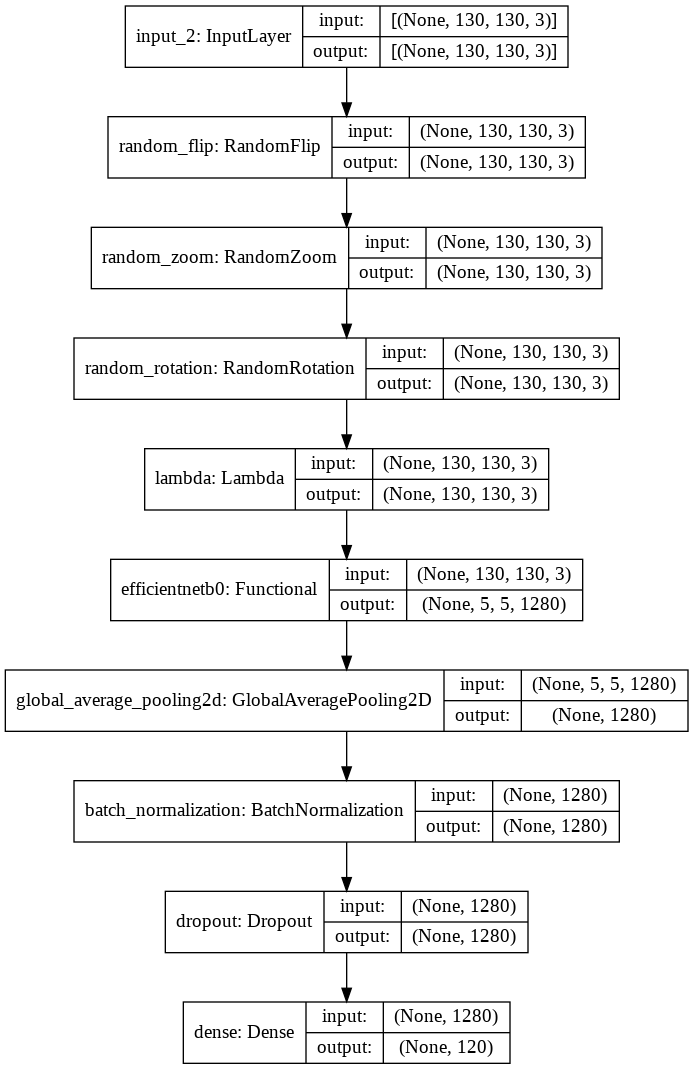

In [ ]:
model = build_warmup_parametrized_model(0.7,regularization="dropout");
tf.keras.utils.plot_model(model, "efficientnetb0.png",show_shapes=True)

We can test how an image is randomly augmented:

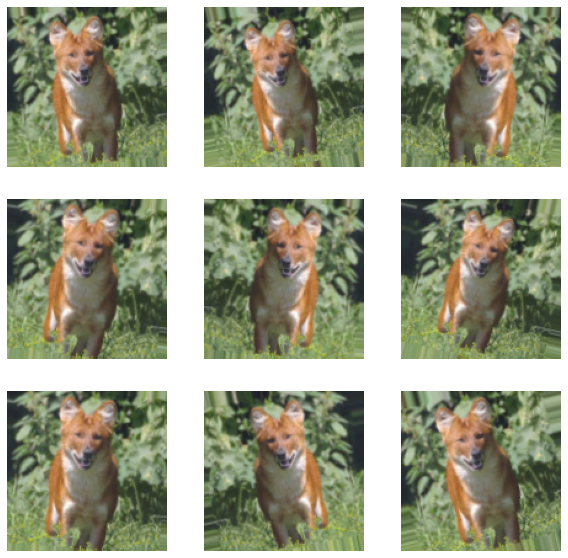

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
      tf.keras.layers.experimental.preprocessing.RandomZoom((-0.1,0.1)),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.04,fill_mode='nearest') #15 deg = 0.26 rad = 4% of 2 pi rad
])

plt.figure(figsize=(10, 10))
first_image = X_train[1]
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
  plt.imshow(augmented_image[0] / 255)
  plt.axis('off')

# Transfer learning with EfficientNetB0


## Cross-validation for warm-up
Here we are going to tune the hyperparameters for warm-up training starting from the EfficientNetB0 base model. The hyperparameters are:
- the optimizer (SGD/Adam)
- the loss function (KL divergence/categorical cross-entropy)
- the type of regularization (L2 with lambda=0.05, 0.1, and dropout with p=0.7)
- the learning rate (0.005, 0.01)

We are going to do two different cross validations, one with L2 regularization and one with dropout.

### CV with L2 regularization
3 folds x 2 learning rates x 2 optimizers x 2 losses x 2 lambdas = 48 ten-epoch fits, each one lasting on average 1.1m using Colab's GPU. 

Total time = 53m

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
lrates =  [5e-03, 1e-02]

gc.collect()

params={'optimizer':["SGD","Adam"],'loss':['kl_divergence','categorical_crossentropy'],'regularization':['l2'],'reg_param':[0.05,0.1],'learning_rate':lrates,'base_net':['EfficientNetB0']}
batch_size=64
estimator= KerasClassifier(build_fn=build_warmup_parametrized_model, batch_size=batch_size)
rs_l2 = GridSearchCV(estimator, param_grid=params, n_jobs=1,cv=3,verbose=4,pre_dispatch=1)

rs_l2.fit(X_train, y_train,epochs=10)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] base_net=EfficientNetB0, learning_rate=0.005, loss=kl_divergence, optimizer=SGD, reg_param=0.05, regularization=l2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


16711680/16705208 [==============================] - 0s 0us/step
Epoch 1/10
84/84 [==============================] - 17s 59ms/step - loss: 14.0081 - accuracy: 0.1135
Epoch 2/10
84/84 [==============================] - 5s 57ms/step - loss: 6.2625 - accuracy: 0.5672
Epoch 3/10
84/84 [==============================] - 5s 57ms/step - loss: 3.8032 - accuracy: 0.6505
Epoch 4/10
84/84 [==============================] - 5s 57ms/step - loss: 2.8016 - accuracy: 0.6821
Epoch 5/10
84/84 [==============================] - 5s 57ms/step - loss: 2.3878 - accuracy: 0.7294
Epoch 6/10
84/84 [==============================] - 5s 57ms/step - loss: 2.2419 - accuracy: 0.7237
Epoch 7/10
84/84 [==============================] - 5s 56ms/step - loss: 2.1773 - accuracy: 0.7317
Epoch 8/10
84/84 [==============================] - 5s 56ms/step - loss: 2.1305 - accuracy: 0.7199
Epoch 9/10
84/84 [==============================] - 5s 56ms/step - loss: 2.1185 - accuracy: 0.7343
Epoch 10/10
42/42 [=======================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 9s 57ms/step - loss: 13.9663 - accuracy: 0.1168
Epoch 2/10
84/84 [==============================] - 5s 57ms/step - loss: 6.2403 - accuracy: 0.5657
Epoch 3/10
84/84 [==============================] - 5s 56ms/step - loss: 3.7793 - accuracy: 0.6506
Epoch 4/10
84/84 [==============================] - 5s 56ms/step - loss: 2.7556 - accuracy: 0.7103
Epoch 5/10
84/84 [==============================] - 5s 56ms/step - loss: 2.3917 - accuracy: 0.7113
Epoch 6/10
84/84 [==============================] - 5s 56ms/step - loss: 2.2229 - accuracy: 0.7142
Epoch 7/10
84/84 [==============================] - 5s 56ms/step - loss: 2.1811 - accuracy: 0.7153
Epoch 8/10
84/84 [==============================] - 5s 57ms/step - loss: 2.1493 - accuracy: 0.7113
Epoch 9/10
84/84 [==============================] - 5s 56ms/step - loss: 2.1302 - accuracy: 0.7301
Epoch 10/10
42/42 [==============================] - 3s 49ms/step - loss: 2.3132 - accuracy: 0.6037
[CV]  ba

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 10s 60ms/step - loss: 14.0542 - accuracy: 0.1145
Epoch 2/10
84/84 [==============================] - 5s 57ms/step - loss: 6.2891 - accuracy: 0.5623
Epoch 3/10
84/84 [==============================] - 5s 57ms/step - loss: 3.7811 - accuracy: 0.6533
Epoch 4/10
84/84 [==============================] - 5s 57ms/step - loss: 2.7843 - accuracy: 0.6876
Epoch 5/10
84/84 [==============================] - 5s 57ms/step - loss: 2.4192 - accuracy: 0.6991
Epoch 6/10
84/84 [==============================] - 5s 57ms/step - loss: 2.2242 - accuracy: 0.7245
Epoch 7/10
84/84 [==============================] - 5s 57ms/step - loss: 2.1686 - accuracy: 0.7141
Epoch 8/10
84/84 [==============================] - 5s 57ms/step - loss: 2.1365 - accuracy: 0.7281
Epoch 9/10
84/84 [==============================] - 5s 57ms/step - loss: 2.1545 - accuracy: 0.7142
Epoch 10/10
42/42 [==============================] - 3s 55ms/step - loss: 2.3094 - accuracy: 0.6069
[CV]  b

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.1min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 9s 57ms/step - loss: 21.4301 - accuracy: 0.1194
Epoch 2/10
84/84 [==============================] - 5s 57ms/step - loss: 5.4961 - accuracy: 0.5576
Epoch 3/10
84/84 [==============================] - 5s 56ms/step - loss: 3.1178 - accuracy: 0.6261
Epoch 4/10
84/84 [==============================] - 5s 57ms/step - loss: 2.7728 - accuracy: 0.6384
Epoch 5/10
84/84 [==============================] - 5s 57ms/step - loss: 2.7153 - accuracy: 0.6321
Epoch 6/10
84/84 [==============================] - 5s 56ms/step - loss: 2.6861 - accuracy: 0.6333
Epoch 7/10
84/84 [==============================] - 5s 57ms/step - loss: 2.6722 - accuracy: 0.6507
Epoch 8/10
84/84 [==============================] - 5s 57ms/step - loss: 2.6928 - accuracy: 0.6404
Epoch 9/10
84/84 [==============================] - 5s 57ms/step - loss: 2.6666 - accuracy: 0.6457
Epoch 10/10
42/42 [==============================] - 3s 50ms/step - loss: 2.6532 - accuracy: 0.5786
[CV]  ba

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 50.2min finished


Epoch 1/10
125/125 [==============================] - 11s 57ms/step - loss: 12.8901 - accuracy: 0.1701
Epoch 2/10
125/125 [==============================] - 7s 57ms/step - loss: 4.6303 - accuracy: 0.5817
Epoch 3/10
125/125 [==============================] - 7s 57ms/step - loss: 2.8509 - accuracy: 0.6394
Epoch 4/10
125/125 [==============================] - 7s 57ms/step - loss: 2.3812 - accuracy: 0.6681
Epoch 5/10
125/125 [==============================] - 7s 57ms/step - loss: 2.2814 - accuracy: 0.6692
Epoch 6/10
125/125 [==============================] - 7s 57ms/step - loss: 2.2138 - accuracy: 0.6785
Epoch 7/10
125/125 [==============================] - 7s 57ms/step - loss: 2.2098 - accuracy: 0.6772
Epoch 8/10
125/125 [==============================] - 7s 57ms/step - loss: 2.1970 - accuracy: 0.6770
Epoch 9/10
125/125 [==============================] - 7s 57ms/step - loss: 2.2014 - accuracy: 0.6711
Epoch 10/10
125/125 [==============================] - 7s 57ms/step - loss: 2.1774 - accu

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f878f9043c8>,
             iid='deprecated', n_jobs=1,
             param_grid={'base_net': ['EfficientNetB0'],
                         'learning_rate': [0.005, 0.01],
                         'loss': ['kl_divergence', 'categorical_crossentropy'],
                         'optimizer': ['SGD', 'Adam'], 'reg_param': [0.05, 0.1],
                         'regularization': ['l2']},
             pre_dispatch=1, refit=True, return_train_score=False, scoring=None,
             verbose=4)

In [ ]:
print(rs_l2.best_score_)
print(rs_l2.best_params_)

0.6072508096694946
{'base_net': 'EfficientNetB0', 'learning_rate': 0.005, 'loss': 'categorical_crossentropy', 'optimizer': 'SGD', 'reg_param': 0.05, 'regularization': 'l2'}


### CV with Dropout

3 folds x 2 learning rates x 2 optimizers x 2 losses x 1 p = 24 ten-epoch fits, each one lasting on average 1.1m using Colab's GPU. 

Total time = 26.4m

In [ ]:
gc.collect()

params={'optimizer':["SGD","Adam"],'loss':['kl_divergence','categorical_crossentropy'],'regularization':['dropout'],'reg_param':[0.7],'learning_rate':lrates,'base_net':['EfficientNetB0']}
rs_dropout = GridSearchCV(estimator, param_grid=params, n_jobs=1,cv=3,verbose=4,pre_dispatch=1)
rs_dropout.fit(X_train, y_train,epochs=10)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] base_net=EfficientNetB0, learning_rate=0.005, loss=kl_divergence, optimizer=SGD, reg_param=0.7, regularization=dropout 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
84/84 [==============================] - 9s 58ms/step - loss: 6.3706 - accuracy: 0.0519
Epoch 2/10
84/84 [==============================] - 5s 57ms/step - loss: 3.0379 - accuracy: 0.3208
Epoch 3/10
84/84 [==============================] - 5s 57ms/step - loss: 2.3909 - accuracy: 0.4345
Epoch 4/10
84/84 [==============================] - 5s 57ms/step - loss: 2.1431 - accuracy: 0.4748
Epoch 5/10
84/84 [==============================] - 5s 58ms/step - loss: 1.9261 - accuracy: 0.5161
Epoch 6/10
84/84 [==============================] - 5s 57ms/step - loss: 1.7952 - accuracy: 0.5338
Epoch 7/10
84/84 [==============================] - 5s 57ms/step - loss: 1.6740 - accuracy: 0.5577
Epoch 8/10
84/84 [==============================] - 5s 57ms/step - loss: 1.6047 - accuracy: 0.5697
Epoch 9/10
84/84 [==============================] - 5s 58ms/step - loss: 1.4963 - accuracy: 0.6009
Epoch 10/10
42/42 [==============================] - 3s 50ms/step - loss: 1.4958 - accuracy: 0.6074
[CV]  bas

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 9s 57ms/step - loss: 6.1553 - accuracy: 0.0556
Epoch 2/10
84/84 [==============================] - 5s 57ms/step - loss: 3.1025 - accuracy: 0.3077
Epoch 3/10
84/84 [==============================] - 5s 58ms/step - loss: 2.4428 - accuracy: 0.4244
Epoch 4/10
84/84 [==============================] - 5s 57ms/step - loss: 2.1327 - accuracy: 0.4819
Epoch 5/10
84/84 [==============================] - 5s 57ms/step - loss: 1.9320 - accuracy: 0.5036
Epoch 6/10
84/84 [==============================] - 5s 58ms/step - loss: 1.7653 - accuracy: 0.5424
Epoch 7/10
84/84 [==============================] - 5s 58ms/step - loss: 1.6245 - accuracy: 0.5670
Epoch 8/10
84/84 [==============================] - 5s 58ms/step - loss: 1.5913 - accuracy: 0.5692
Epoch 9/10
84/84 [==============================] - 5s 58ms/step - loss: 1.4126 - accuracy: 0.6100
Epoch 10/10
42/42 [==============================] - 3s 49ms/step - loss: 1.4892 - accuracy: 0.6018
[CV]  bas

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 9s 57ms/step - loss: 6.2861 - accuracy: 0.0509
Epoch 2/10
84/84 [==============================] - 5s 57ms/step - loss: 3.1681 - accuracy: 0.3066
Epoch 3/10
84/84 [==============================] - 5s 57ms/step - loss: 2.4860 - accuracy: 0.4337
Epoch 4/10
84/84 [==============================] - 5s 57ms/step - loss: 2.1748 - accuracy: 0.4771
Epoch 5/10
84/84 [==============================] - 5s 57ms/step - loss: 1.8992 - accuracy: 0.5273
Epoch 6/10
84/84 [==============================] - 5s 57ms/step - loss: 1.7594 - accuracy: 0.5416
Epoch 7/10
84/84 [==============================] - 5s 57ms/step - loss: 1.6580 - accuracy: 0.5685
Epoch 8/10
84/84 [==============================] - 5s 57ms/step - loss: 1.5907 - accuracy: 0.5848
Epoch 9/10
84/84 [==============================] - 5s 57ms/step - loss: 1.4705 - accuracy: 0.6009
Epoch 10/10
42/42 [==============================] - 3s 49ms/step - loss: 1.4948 - accuracy: 0.6129
[CV]  bas

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.1min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 9s 57ms/step - loss: 5.3284 - accuracy: 0.1362
Epoch 2/10
84/84 [==============================] - 5s 57ms/step - loss: 2.7281 - accuracy: 0.4499
Epoch 3/10
84/84 [==============================] - 5s 57ms/step - loss: 2.4290 - accuracy: 0.4967
Epoch 4/10
84/84 [==============================] - 5s 57ms/step - loss: 2.2419 - accuracy: 0.5198
Epoch 5/10
84/84 [==============================] - 5s 57ms/step - loss: 1.9928 - accuracy: 0.5649
Epoch 6/10
84/84 [==============================] - 5s 57ms/step - loss: 1.7839 - accuracy: 0.5932
Epoch 7/10
84/84 [==============================] - 5s 57ms/step - loss: 1.6506 - accuracy: 0.6027
Epoch 8/10
84/84 [==============================] - 5s 57ms/step - loss: 1.6781 - accuracy: 0.5942
Epoch 9/10
84/84 [==============================] - 5s 57ms/step - loss: 1.5318 - accuracy: 0.6255
Epoch 10/10
42/42 [==============================] - 3s 49ms/step - loss: 1.7864 - accuracy: 0.5801
[CV]  bas

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 25.0min finished


Epoch 1/10
125/125 [==============================] - 11s 57ms/step - loss: 5.8916 - accuracy: 0.0777
Epoch 2/10
125/125 [==============================] - 7s 56ms/step - loss: 2.7913 - accuracy: 0.3625
Epoch 3/10
125/125 [==============================] - 7s 56ms/step - loss: 2.2876 - accuracy: 0.4467
Epoch 4/10
125/125 [==============================] - 7s 57ms/step - loss: 2.0712 - accuracy: 0.4935
Epoch 5/10
125/125 [==============================] - 7s 57ms/step - loss: 1.8846 - accuracy: 0.5283
Epoch 6/10
125/125 [==============================] - 7s 57ms/step - loss: 1.7333 - accuracy: 0.5584
Epoch 7/10
125/125 [==============================] - 7s 56ms/step - loss: 1.6895 - accuracy: 0.5537
Epoch 8/10
125/125 [==============================] - 7s 57ms/step - loss: 1.5853 - accuracy: 0.5830
Epoch 9/10
125/125 [==============================] - 7s 57ms/step - loss: 1.5069 - accuracy: 0.5957
Epoch 10/10
125/125 [==============================] - 7s 57ms/step - loss: 1.5092 - accur

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f878f9043c8>,
             iid='deprecated', n_jobs=1,
             param_grid={'base_net': ['EfficientNetB0'],
                         'learning_rate': [0.005, 0.01],
                         'loss': ['kl_divergence', 'categorical_crossentropy'],
                         'optimizer': ['SGD', 'Adam'], 'reg_param': [0.7],
                         'regularization': ['dropout']},
             pre_dispatch=1, refit=True, return_train_score=False, scoring=None,
             verbose=4)

In [ ]:
print(rs_dropout.best_score_)
print(rs_dropout.best_params_)

0.607375701268514
{'base_net': 'EfficientNetB0', 'learning_rate': 0.005, 'loss': 'kl_divergence', 'optimizer': 'SGD', 'reg_param': 0.7, 'regularization': 'dropout'}


## Warm-up with best hyperparameters
With the best hyperparameters for the L2 case, the mean validation accuracy is 0.6073, but the mean training accuracy is around 0.73, which is a symptom of overfitting. Instead, with the best hyperparameters for the Dropout case, we get a mean validation accuracy equal to 0.6074 and a mean training accuracy around 0.60, so no overfitting. Both because the mean accuracy is higher for the Dropout case and because there's no overfitting we prefer Dropout regularization.

The best hyperparameters are:
- LR = 0.005 
- Optimizer = SGD
- p = 0.7
- Loss = KL divergence

Since we now want to find the best hyperparameters for fine-tuning, we shall now perform the actual warm-up.

Notice, however, that later we shouldn't cross-validate on the training set again, since the network has already seen those validation samples earlier during warm-up. 

So, we do the warm-up only on the first 7040 samples of the training set and, to find the best hyperparameters for fine-tuning, instead of cross-validating again we just use the first 7040 samples as a training set and the last 960 samples (belonging to the original training set) as a validation set. This way, the validation accuracy will not be overestimated, since the network was never trained on those samples before.

Even though Dropout already regularizes, we use Early Stopping to furtherly avoid overfitting.

So, we now do the warm-up:

Epoch 1/20
110/110 [==============================] - 12s 73ms/step - loss: 6.0041 - accuracy: 0.0644 - val_loss: 2.3135 - val_accuracy: 0.5031
Epoch 2/20
110/110 [==============================] - 7s 62ms/step - loss: 2.8758 - accuracy: 0.3540 - val_loss: 1.5690 - val_accuracy: 0.5771
Epoch 3/20
110/110 [==============================] - 7s 62ms/step - loss: 2.4150 - accuracy: 0.4232 - val_loss: 1.4547 - val_accuracy: 0.5792
Epoch 4/20
110/110 [==============================] - 7s 62ms/step - loss: 2.0970 - accuracy: 0.4878 - val_loss: 1.4624 - val_accuracy: 0.5906
Epoch 5/20
110/110 [==============================] - 7s 62ms/step - loss: 1.9111 - accuracy: 0.5268 - val_loss: 1.4313 - val_accuracy: 0.6042
Epoch 6/20
110/110 [==============================] - 7s 62ms/step - loss: 1.7676 - accuracy: 0.5490 - val_loss: 1.4435 - val_accuracy: 0.6083
Epoch 7/20
110/110 [==============================] - 7s 62ms/step - loss: 1.6943 - accuracy: 0.5662 - val_loss: 1.4286 - val_accuracy: 0.613

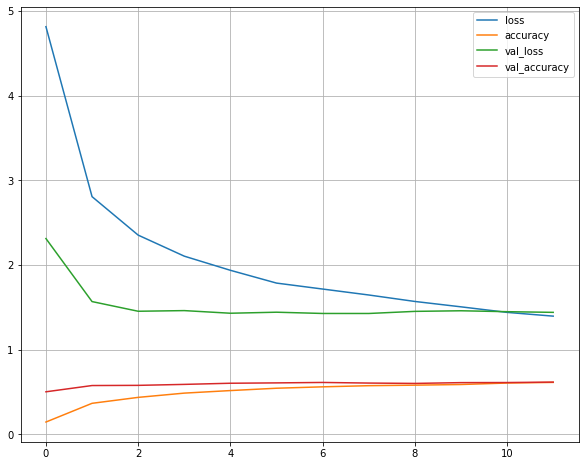

In [ ]:
warmup_model = build_warmup_parametrized_model(regularization="dropout",reg_param=0.7,optimizer="SGD", learning_rate=0.005,loss="kl_divergence")
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
batch_size = 64
steps_per_epoch = X_train[0:7040].shape[0] // batch_size 
validation_steps = X_train[7040:8000].shape[0] // batch_size 

history = warmup_model.fit(X_train[0:7040],y_train[0:7040],steps_per_epoch=steps_per_epoch, epochs=20, validation_data=(X_train[7040:8000],y_train[7040:8000]),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)
warmup_model.save_weights("warmup.hd5")
del warmup_model
gc.collect()
tf.keras.backend.clear_session()

## Hyperparameter tuning for fine-tuning
Now we have to do the warmup with these hyperparameters and then, starting from the resulting model, repeat the cross validation, applying it to the fine tuning step. We have to tune the following hyperparameters:
- LR, with values 1e-4, 5e-4
- K = 50, 150* (number of base layers to freeze)
- Loss (KL/categorical cross-entropy)

We keep the Dropout regularization but we rise p to 0.8, since this stage is more delicate and incurring in overfitting is easier.
We also keep the SGD optimizer.

*As we can see in the following cell, there are 236 layers.

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', input_shape=(130, 130, 3), include_top=False)

for k, layer in enumerate(base_model.layers):
  print(str(k) + " " + layer.name)

0 input_6
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

The following validation lasted around 19 minutes.

In [ ]:
from sklearn.model_selection import KFold
from termcolor import colored

max_accuracy=0

for K in [100,150]:
  for loss in ['kl_divergence','categorical_crossentropy']: 
    for learning_rate in [1e-4,5e-4]:
        print(colored("\n\n\n\nK: "+str(K)+", Loss: "+str(loss)+", LR: "+str(learning_rate),"blue"));
        validation_steps = X_train[7040:8000].shape[0] // batch_size 
        steps_per_epoch = X_train[0:7040].shape[0] // batch_size 
    
        model = build_finetuning_parametrized_model(0.8,K,regularization="dropout",optimizer="SGD", loss=loss,learning_rate=learning_rate)


        history = model.fit(X_train[0:7040], y_train[0:7040],
                            steps_per_epoch=steps_per_epoch, 
                            validation_data=(X_train[7040:8000],y_train[7040:8000]), 
                            validation_steps=validation_steps,
                            epochs=10, verbose=1, callbacks=[callback])
        accuracy = history.history['val_accuracy'][-1] 

        del model 
        tf.keras.backend.clear_session()  
        gc.collect()
        
        
        print(colored("Accuracy: "+str(accuracy)+" K: "+str(K)+" Loss: "+str(loss)+" LR: "+str(learning_rate),"green"));
        if accuracy > max_accuracy:
          max_accuracy = accuracy
          best_fine_K = K
          best_fine_lr = learning_rate
          best_fine_loss = loss
max_accuracy



  





K: 100, Loss: kl_divergence, LR: 0.0005
Epoch 1/10
110/110 [==============================] - 19s 133ms/step - loss: 1.8256 - accuracy: 0.5458 - val_loss: 1.3977 - val_accuracy: 0.6146
Epoch 2/10
110/110 [==============================] - 13s 122ms/step - loss: 1.6594 - accuracy: 0.5834 - val_loss: 1.3830 - val_accuracy: 0.6281
Epoch 3/10
110/110 [==============================] - 13s 122ms/step - loss: 1.6464 - accuracy: 0.5671 - val_loss: 1.3665 - val_accuracy: 0.6354
Epoch 4/10
110/110 [==============================] - 14s 123ms/step - loss: 1.4736 - accuracy: 0.6166 - val_loss: 1.4033 - val_accuracy: 0.6219
Epoch 5/10
110/110 [==============================] - 14s 123ms/step - loss: 1.4367 - accuracy: 0.6215 - val_loss: 1.3956 - val_accuracy: 0.6302
Epoch 6/10
110/110 [==============================] - 14s 123ms/step - loss: 1.3928 - accuracy: 0.6251 - val_loss: 1.3582 - val_accuracy: 0.6427
Epoch 7/10
110/110 [==============================] - 14s 123ms/step - loss: 1.3413 - 

0.6572916507720947

In [ ]:
print(best_fine_K)
print(best_fine_lr)
print(best_fine_loss)
print(max_accuracy)

100
0.0005
kl_divergence
0.6572916507720947


## Empirical proof that we can't repeat CV on whole dataset

To prove that we couldn't repeat the cross-validation on the whole training set, we repeat the warm-up on it and then we estimate the validation accuracy in fine tuning using the best hyperparameters for fine tuning that we calculated above (we could use the same grid of hyperparameters, but we directly use the best ones so that we know what accuracy to expect).

16711680/16705208 [==============================] - 0s 0us/step
Epoch 1/20
125/125 [==============================] - 21s 79ms/step - loss: 5.8952 - accuracy: 0.0770 - val_loss: 2.1779 - val_accuracy: 0.5170
Epoch 2/20
125/125 [==============================] - 8s 62ms/step - loss: 2.8408 - accuracy: 0.3530 - val_loss: 1.5070 - val_accuracy: 0.5900
Epoch 3/20
125/125 [==============================] - 8s 62ms/step - loss: 2.3442 - accuracy: 0.4491 - val_loss: 1.4571 - val_accuracy: 0.5790
Epoch 4/20
125/125 [==============================] - 8s 62ms/step - loss: 2.0710 - accuracy: 0.4916 - val_loss: 1.4749 - val_accuracy: 0.5960
Epoch 5/20
125/125 [==============================] - 8s 63ms/step - loss: 1.9696 - accuracy: 0.5037 - val_loss: 1.4482 - val_accuracy: 0.6120
Epoch 6/20
125/125 [==============================] - 8s 63ms/step - loss: 1.7473 - accuracy: 0.5518 - val_loss: 1.4729 - val_accuracy: 0.6110
Epoch 7/20
125/125 [==============================] - 8s 64ms/step - loss: 1

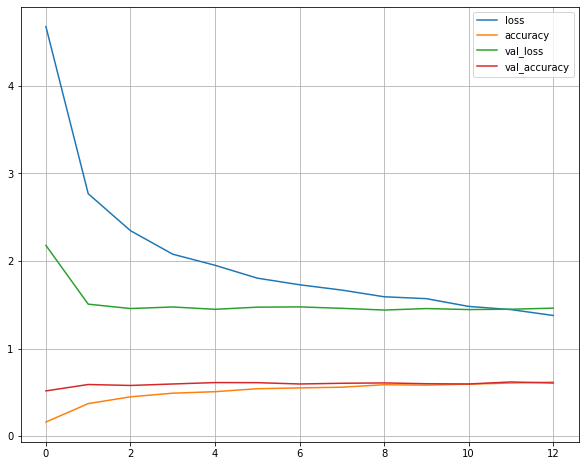

In [ ]:
warmup_model = build_warmup_parametrized_model(regularization="dropout",reg_param=0.7,optimizer="SGD", learning_rate=0.005,loss="kl_divergence")
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
batch_size = 64
steps_per_epoch = X_train.shape[0] // batch_size 
validation_steps = X_test.shape[0] // batch_size 

history = warmup_model.fit(X_train,y_train,steps_per_epoch=steps_per_epoch, epochs=20, validation_data=(X_test,y_test),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)
warmup_model.save_weights("warmup.hd5")
del warmup_model
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

params={'K':[100],'optimizer':["SGD"],'loss':['kl_divergence'],'regularization':['dropout'],'reg_param':[0.8],'learning_rate':[5e-4],'base_net':['EfficientNetB0']}
batch_size=64
estimator= KerasClassifier(build_fn=build_finetuning_parametrized_model, batch_size=batch_size)
rs = GridSearchCV(estimator, param_grid=params, n_jobs=1,cv=3,verbose=4,pre_dispatch=1)

rs.fit(X_train, y_train,epochs=10)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] K=100, base_net=EfficientNetB0, learning_rate=0.0005, loss=kl_divergence, optimizer=SGD, reg_param=0.8, regularization=dropout 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
84/84 [==============================] - 16s 120ms/step - loss: 1.8578 - accuracy: 0.5415
Epoch 2/10
84/84 [==============================] - 10s 120ms/step - loss: 1.6513 - accuracy: 0.5802
Epoch 3/10
84/84 [==============================] - 10s 119ms/step - loss: 1.5609 - accuracy: 0.5876
Epoch 4/10
84/84 [==============================] - 10s 118ms/step - loss: 1.4726 - accuracy: 0.6151
Epoch 5/10
84/84 [==============================] - 10s 118ms/step - loss: 1.3513 - accuracy: 0.6352
Epoch 6/10
84/84 [==============================] - 10s 117ms/step - loss: 1.3122 - accuracy: 0.6484
Epoch 7/10
84/84 [==============================] - 10s 117ms/step - loss: 1.3118 - accuracy: 0.6427
Epoch 8/10
84/84 [==============================] - 10s 118ms/step - loss: 1.2246 - accuracy: 0.6633
Epoch 9/10
84/84 [==============================] - 10s 118ms/step - loss: 1.2298 - accuracy: 0.6565
Epoch 10/10
42/42 [==============================] - 3s 50ms/step - loss: 0.6761 - accuracy

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 15s 118ms/step - loss: 1.8000 - accuracy: 0.5514
Epoch 2/10
84/84 [==============================] - 10s 118ms/step - loss: 1.5930 - accuracy: 0.5896
Epoch 3/10
84/84 [==============================] - 10s 119ms/step - loss: 1.5695 - accuracy: 0.5776
Epoch 4/10
84/84 [==============================] - 10s 119ms/step - loss: 1.4619 - accuracy: 0.6193
Epoch 5/10
84/84 [==============================] - 10s 118ms/step - loss: 1.3833 - accuracy: 0.6280
Epoch 6/10
84/84 [==============================] - 10s 118ms/step - loss: 1.3737 - accuracy: 0.6204
Epoch 7/10
84/84 [==============================] - 10s 117ms/step - loss: 1.2481 - accuracy: 0.6539
Epoch 8/10
84/84 [==============================] - 10s 117ms/step - loss: 1.2162 - accuracy: 0.6586
Epoch 9/10
84/84 [==============================] - 10s 117ms/step - loss: 1.2390 - accuracy: 0.6686
Epoch 10/10
42/42 [==============================] - 3s 49ms/step - loss: 0.6624 - accuracy

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 16s 118ms/step - loss: 1.8383 - accuracy: 0.5477
Epoch 2/10
84/84 [==============================] - 10s 119ms/step - loss: 1.6418 - accuracy: 0.5726
Epoch 3/10
84/84 [==============================] - 10s 120ms/step - loss: 1.6183 - accuracy: 0.5903
Epoch 4/10
84/84 [==============================] - 10s 119ms/step - loss: 1.4728 - accuracy: 0.6191
Epoch 5/10
84/84 [==============================] - 10s 118ms/step - loss: 1.3778 - accuracy: 0.6449
Epoch 6/10
84/84 [==============================] - 10s 117ms/step - loss: 1.3922 - accuracy: 0.6377
Epoch 7/10
84/84 [==============================] - 10s 117ms/step - loss: 1.2789 - accuracy: 0.6505
Epoch 8/10
84/84 [==============================] - 10s 117ms/step - loss: 1.2784 - accuracy: 0.6437
Epoch 9/10
84/84 [==============================] - 10s 118ms/step - loss: 1.2008 - accuracy: 0.6573
Epoch 10/10
42/42 [==============================] - 3s 50ms/step - loss: 0.7036 - accuracy

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min finished


Epoch 1/10
125/125 [==============================] - 19s 115ms/step - loss: 1.7517 - accuracy: 0.5585
Epoch 2/10
125/125 [==============================] - 14s 116ms/step - loss: 1.6370 - accuracy: 0.5854
Epoch 3/10
125/125 [==============================] - 14s 115ms/step - loss: 1.5543 - accuracy: 0.5943
Epoch 4/10
125/125 [==============================] - 14s 115ms/step - loss: 1.4464 - accuracy: 0.6234
Epoch 5/10
125/125 [==============================] - 14s 114ms/step - loss: 1.4321 - accuracy: 0.6123
Epoch 6/10
125/125 [==============================] - 14s 114ms/step - loss: 1.3364 - accuracy: 0.6420
Epoch 7/10
125/125 [==============================] - 14s 115ms/step - loss: 1.3171 - accuracy: 0.6456
Epoch 8/10
125/125 [==============================] - 14s 115ms/step - loss: 1.2594 - accuracy: 0.6578
Epoch 9/10
125/125 [==============================] - 14s 115ms/step - loss: 1.2090 - accuracy: 0.6633
Epoch 10/10
125/125 [==============================] - 14s 115ms/step - l

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd2603ee7b8>,
             iid='deprecated', n_jobs=1,
             param_grid={'K': [100], 'base_net': ['EfficientNetB0'],
                         'learning_rate': [0.0005], 'loss': ['kl_divergence'],
                         'optimizer': ['SGD'], 'reg_param': [0.8],
                         'regularization': ['dropout']},
             pre_dispatch=1, refit=True, return_train_score=False, scoring=None,
             verbose=4)

In [ ]:
print(rs.best_score_)

0.7943743666013082


As we can see, we get a way higher validation accuracy (79.4%), which is definitely a wrong estimate.

## Full training and testing

Having found an estimate of the best hyperparameters, we can now do the warm-up and then fine-tune on the whole training set, using the best hyperparameters for warm-up and fine-tuning respectively.

To recap, for warm-up they are:
- LR = 0.005 
- Optimizer = SGD
- Dropout (p = 0.7)
- Loss = KL divergence

and for fine-tuning (setting optimizer=SGD and using Dropout with p=0.8):
- K = 100
- LR = 0.0005
- Loss = KL divergence

With warm-up we reach 61.4% accuracy. After fine-tuning, we reach 65.1% accuracy.

### Warm-up + fine-tuning

Epoch 1/50
125/125 [==============================] - 13s 72ms/step - loss: 5.7698 - accuracy: 0.0883 - val_loss: 2.1346 - val_accuracy: 0.5270
Epoch 2/50
125/125 [==============================] - 8s 62ms/step - loss: 2.8328 - accuracy: 0.3703 - val_loss: 1.4776 - val_accuracy: 0.5830
Epoch 3/50
125/125 [==============================] - 8s 62ms/step - loss: 2.3166 - accuracy: 0.4464 - val_loss: 1.3686 - val_accuracy: 0.5920
Epoch 4/50
125/125 [==============================] - 8s 62ms/step - loss: 2.0802 - accuracy: 0.4883 - val_loss: 1.3718 - val_accuracy: 0.6070
Epoch 5/50
125/125 [==============================] - 8s 62ms/step - loss: 1.9488 - accuracy: 0.5177 - val_loss: 1.3703 - val_accuracy: 0.6160
Epoch 6/50
125/125 [==============================] - 8s 62ms/step - loss: 1.8038 - accuracy: 0.5393 - val_loss: 1.3935 - val_accuracy: 0.5980
Epoch 7/50
125/125 [==============================] - 8s 62ms/step - loss: 1.6808 - accuracy: 0.5723 - val_loss: 1.3935 - val_accuracy: 0.614

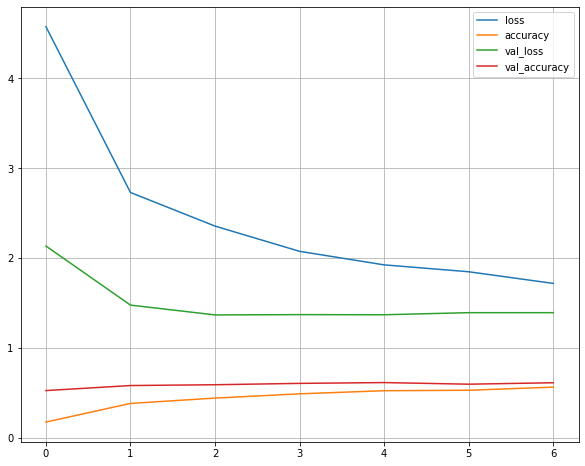

Epoch 1/50
125/125 [==============================] - 21s 130ms/step - loss: 2.0670 - accuracy: 0.5119 - val_loss: 1.3992 - val_accuracy: 0.6010
Epoch 2/50
125/125 [==============================] - 15s 120ms/step - loss: 1.8979 - accuracy: 0.5433 - val_loss: 1.3335 - val_accuracy: 0.6270
Epoch 3/50
125/125 [==============================] - 15s 120ms/step - loss: 1.7334 - accuracy: 0.5603 - val_loss: 1.3139 - val_accuracy: 0.6350
Epoch 4/50
125/125 [==============================] - 15s 121ms/step - loss: 1.6363 - accuracy: 0.5721 - val_loss: 1.2912 - val_accuracy: 0.6350
Epoch 5/50
125/125 [==============================] - 15s 121ms/step - loss: 1.5967 - accuracy: 0.5828 - val_loss: 1.2619 - val_accuracy: 0.6500
Epoch 6/50
125/125 [==============================] - 15s 121ms/step - loss: 1.5191 - accuracy: 0.6022 - val_loss: 1.3077 - val_accuracy: 0.6340
Epoch 7/50
125/125 [==============================] - 15s 122ms/step - loss: 1.5100 - accuracy: 0.6084 - val_loss: 1.2398 - val_ac

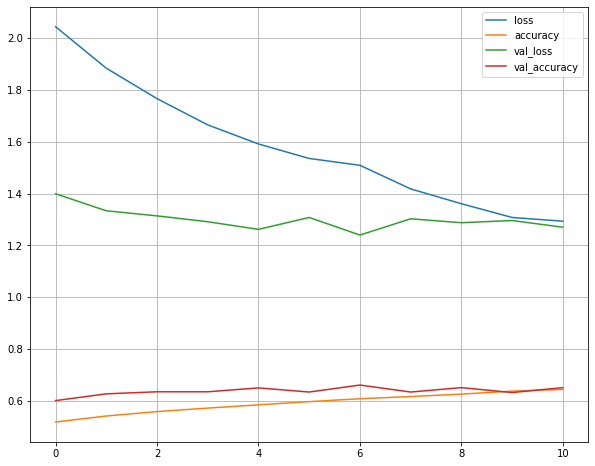

In [ ]:
warmup_model = build_warmup_parametrized_model(0.7,base_net='EfficientNetB0',regularization='dropout',optimizer='SGD',loss='kl_divergence',learning_rate=0.005);
validation_steps = X_test.shape[0] // 64 
steps_per_epoch = X_train.shape[0] // 64

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history = warmup_model.fit(X_train,y_train,steps_per_epoch=steps_per_epoch, epochs=50, validation_data=(X_test,y_test),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)

warmup_model.save_weights("warmup.hd5")
del warmup_model
tf.keras.backend.clear_session()  

final_model = build_finetuning_parametrized_model(0.8,100,base_net='EfficientNetB0',regularization='dropout',optimizer='SGD',learning_rate=0.0005,loss="kl_divergence");
history = final_model.fit(X_train,y_train,steps_per_epoch=steps_per_epoch, epochs=50, validation_data=(X_test,y_test),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)


### Confusion matrix

We can also calculate and plot the confusion matrix on the testing set (the (i,j)-th entry is the number of class-i samples predicted as class-j). The labels are reconverted from one-hot encoding to 0...119.

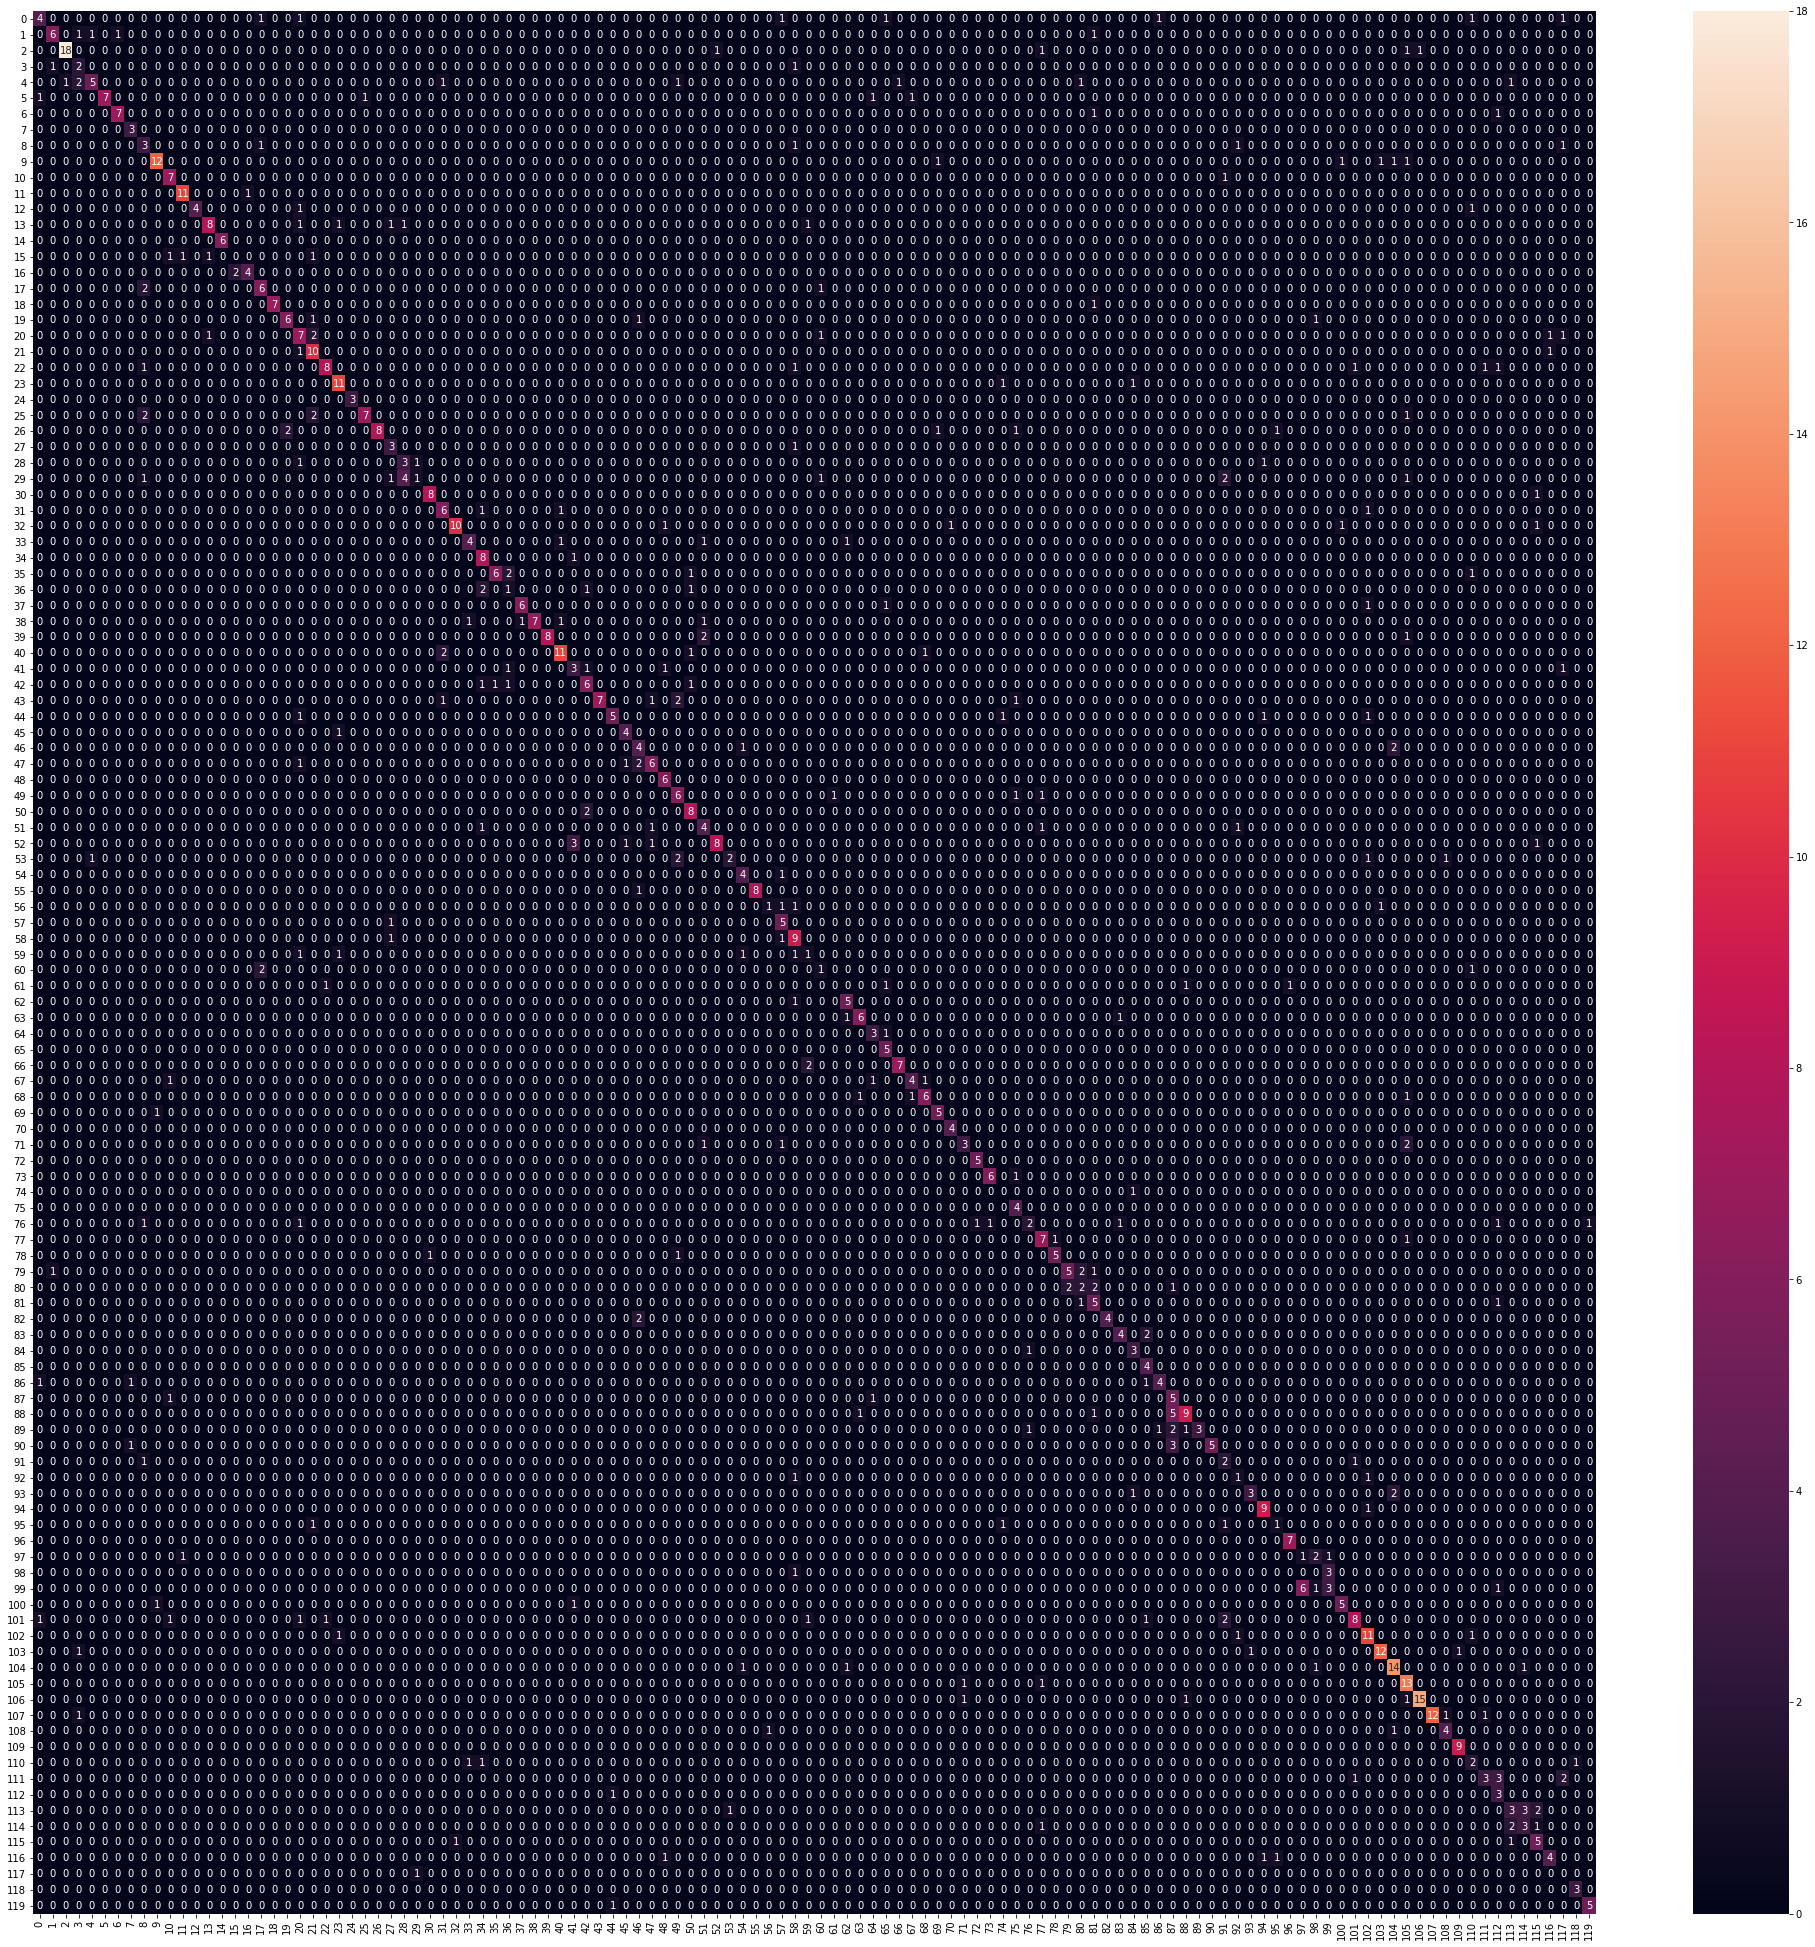

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
y_pred = final_model.predict(X_test);
y_pred = ohe.inverse_transform(y_pred);
y_true = ohe.inverse_transform(y_test);

labels_range = np.asarray(range(0,120));

mat = confusion_matrix(y_true, y_pred, labels=labels_range)
df_cm = pd.DataFrame(mat, index = [i for i in labels_range],
                  columns = [i for i in labels_range])
plt.figure(figsize = (35,35))
sn.heatmap(df_cm, annot=True)

### Class prediction for downloaded image

Finally, we can test the model using an image of a Leonberger dog downloaded from the web (https://worlddogfinder.com/it/razze/leonberger). The true label is 103.


(-0.5, 879.5, 494.5, -0.5)

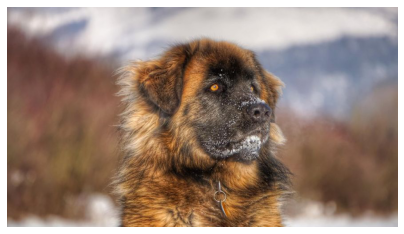

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    "leonberger.jpg", grayscale=False, color_mode='rgb',
    interpolation='nearest'
)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.axis('off')

We now reshape it into a 130x130 image:

(-0.5, 129.5, 129.5, -0.5)

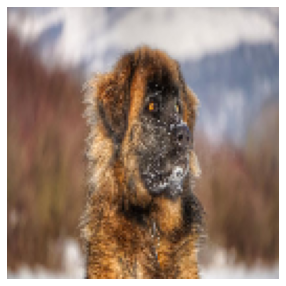

In [ ]:
img = np.asarray(img)
img = tf.image.resize(img, (130,130))
plt.figure(figsize=(5, 5))
plt.imshow(img/255)
plt.axis('off')

And then we use it for predicting the label, knowing that the true label is 103. The prediction is 103, which is correct.

In [ ]:
img = np.asarray([img])
img_y_true = 103
img_y_pred = final_model.predict(img);
img_y_pred = ohe.inverse_transform(img_y_pred);
print("Ground truth: ",img_y_true," Predicted label: ",img_y_pred[0]);

Ground truth:  103  Predicted label:  [103.]


### Performance without data augmentation

Just for the sake of testing, we can see how the training would affect the model if we didn't augment the data (that is, disabling all the preprocessing layers in the model). We see that we reach the same accuracy, but strong overfitting is present making the model undesirable and less generalizable (even though not so much, since a strong regularization effect is already given by the dropout, and a weak one by the Batch Normalization).

Epoch 1/50
125/125 [==============================] - 12s 65ms/step - loss: 5.5664 - accuracy: 0.1036 - val_loss: 2.0141 - val_accuracy: 0.5580
Epoch 2/50
125/125 [==============================] - 7s 55ms/step - loss: 2.3301 - accuracy: 0.4377 - val_loss: 1.4354 - val_accuracy: 0.5830
Epoch 3/50
125/125 [==============================] - 7s 56ms/step - loss: 1.8965 - accuracy: 0.5243 - val_loss: 1.3575 - val_accuracy: 0.6130
Epoch 4/50
125/125 [==============================] - 7s 55ms/step - loss: 1.6510 - accuracy: 0.5601 - val_loss: 1.3898 - val_accuracy: 0.6050
Epoch 5/50
125/125 [==============================] - 7s 56ms/step - loss: 1.4540 - accuracy: 0.6036 - val_loss: 1.3785 - val_accuracy: 0.6080
Epoch 6/50
125/125 [==============================] - 7s 57ms/step - loss: 1.3477 - accuracy: 0.6324 - val_loss: 1.3837 - val_accuracy: 0.6230
Epoch 7/50
125/125 [==============================] - 7s 56ms/step - loss: 1.2458 - accuracy: 0.6485 - val_loss: 1.4056 - val_accuracy: 0.609

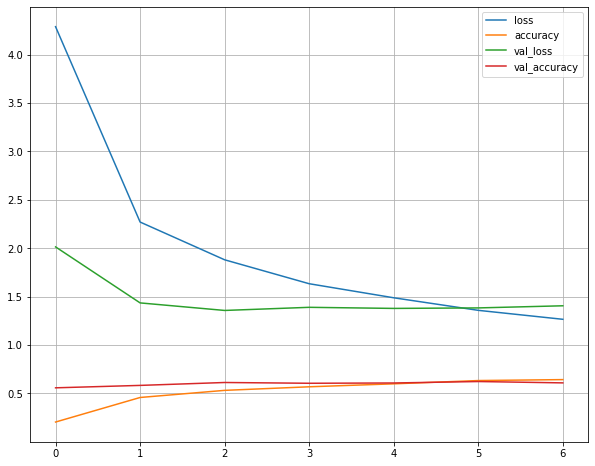

Epoch 1/50
125/125 [==============================] - 20s 123ms/step - loss: 1.6231 - accuracy: 0.5892 - val_loss: 1.2936 - val_accuracy: 0.6320
Epoch 2/50
125/125 [==============================] - 14s 114ms/step - loss: 1.4816 - accuracy: 0.6113 - val_loss: 1.2617 - val_accuracy: 0.6380
Epoch 3/50
125/125 [==============================] - 14s 114ms/step - loss: 1.3215 - accuracy: 0.6403 - val_loss: 1.2405 - val_accuracy: 0.6580
Epoch 4/50
125/125 [==============================] - 14s 114ms/step - loss: 1.2460 - accuracy: 0.6549 - val_loss: 1.2849 - val_accuracy: 0.6470
Epoch 5/50
125/125 [==============================] - 14s 115ms/step - loss: 1.1835 - accuracy: 0.6745 - val_loss: 1.2453 - val_accuracy: 0.6520
Epoch 6/50
125/125 [==============================] - 14s 115ms/step - loss: 1.0758 - accuracy: 0.6868 - val_loss: 1.1998 - val_accuracy: 0.6500
Epoch 7/50
125/125 [==============================] - 14s 115ms/step - loss: 1.0460 - accuracy: 0.7007 - val_loss: 1.1859 - val_ac

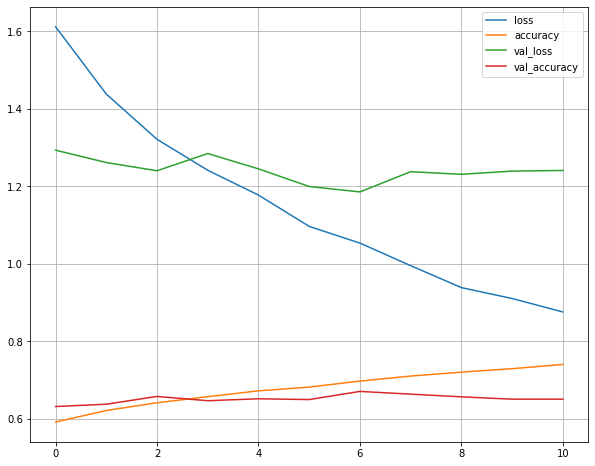

In [ ]:
warmup_model_no_aug = build_warmup_parametrized_model(0.7,with_augmentation=False,base_net='EfficientNetB0',regularization='dropout',optimizer='SGD',loss='kl_divergence',learning_rate=0.005);
validation_steps = X_test.shape[0] // 64 
steps_per_epoch = X_train.shape[0] // 64

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history = warmup_model_no_aug.fit(X_train,y_train,steps_per_epoch=steps_per_epoch, epochs=50, validation_data=(X_test,y_test),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)

warmup_model_no_aug.save_weights("warmup.hd5")
del warmup_model_no_aug
tf.keras.backend.clear_session()  

final_model_no_aug = build_finetuning_parametrized_model(0.8,100,with_augmentation=False,base_net='EfficientNetB0',regularization='dropout',optimizer='SGD',learning_rate=0.0005,loss="kl_divergence");
history = final_model_no_aug.fit(X_train,y_train,steps_per_epoch=steps_per_epoch, epochs=50, validation_data=(X_test,y_test),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)
del final_model_no_aug
tf.keras.backend.clear_session() 

# Transfer learning with DenseNet169

We now repeat the process using the pre-trained DenseNet169 network.
It's better to start a new session and re-execute the cells in "Data preprocessing" and "Architecture building" before proceeding.


## Cross-validation for warm-up
Here we are going to tune the hyperparameters for warm-up training starting from the DenseNet169 base model. The hyperparameters are:
- the optimizer (SGD/Adam)
- the loss function (KL divergence/categorical cross-entropy)
- the type of regularization (L2 with lambda=0.05, 0.1, and dropout with p=0.7)
- the learning rate (0.005, 0.01)

We are going to do two different cross validations, one with L2 regularization and one with dropout.

### CV with L2 regularization
3 folds x 2 learning rates x 2 optimizers x 2 losses x 2 lambdas = 48 ten-epoch fits, each one lasting on average 1.8m using Colab's GPU. 

Total time = 86.4m

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
lrates =  [5e-03, 1e-02]

gc.collect()

params={'optimizer':["SGD","Adam"],'loss':['kl_divergence','categorical_crossentropy'],'regularization':['l2'],'reg_param':[0.05,0.1],'learning_rate':lrates,'base_net':['DenseNet169']}
batch_size=64
estimator= KerasClassifier(build_fn=build_warmup_parametrized_model, batch_size=batch_size)
rs_l2 = GridSearchCV(estimator, param_grid=params, n_jobs=1,cv=3,verbose=4,pre_dispatch=1)

rs_l2.fit(X_train, y_train,epochs=10)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] base_net=DenseNet169, learning_rate=0.005, loss=kl_divergence, optimizer=SGD, reg_param=0.05, regularization=l2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
84/84 [==============================] - 23s 94ms/step - loss: 14.1532 - accuracy: 0.1076
Epoch 2/10
84/84 [==============================] - 7s 86ms/step - loss: 6.5761 - accuracy: 0.5968
Epoch 3/10
84/84 [==============================] - 7s 86ms/step - loss: 4.0258 - accuracy: 0.6816
Epoch 4/10
84/84 [==============================] - 7s 87ms/step - loss: 3.0084 - accuracy: 0.7264
Epoch 5/10
84/84 [==============================] - 7s 88ms/step - loss: 2.5734 - accuracy: 0.7404
Epoch 6/10
84/84 [==============================] - 7s 87ms/step - loss: 2.3962 - accuracy: 0.7359
Epoch 7/10
84/84 [==============================] - 7s 88ms/step - loss: 2.3317 - accuracy: 0.7430
Epoch 8/10
84/84 [==============================] - 7s 88ms/step - loss: 2.2751 - accuracy: 0.7428
Epoch 9/10
84/84 [==============================] - 7s 88ms/step - loss: 2.2621 - accuracy: 0.7577
Epoch 10/10
42/42 [==============================] - 7s 105ms/step - loss: 2.2767 - accuracy: 0.6577
[CV]  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 15s 88ms/step - loss: 14.0192 - accuracy: 0.1206
Epoch 2/10
84/84 [==============================] - 7s 88ms/step - loss: 6.5980 - accuracy: 0.5873
Epoch 3/10
84/84 [==============================] - 7s 88ms/step - loss: 4.0166 - accuracy: 0.6803
Epoch 4/10
84/84 [==============================] - 7s 88ms/step - loss: 2.9705 - accuracy: 0.7258
Epoch 5/10
84/84 [==============================] - 7s 89ms/step - loss: 2.5687 - accuracy: 0.7431
Epoch 6/10
84/84 [==============================] - 7s 89ms/step - loss: 2.3873 - accuracy: 0.7425
Epoch 7/10
84/84 [==============================] - 7s 88ms/step - loss: 2.3287 - accuracy: 0.7346
Epoch 8/10
84/84 [==============================] - 7s 88ms/step - loss: 2.2682 - accuracy: 0.7531
Epoch 9/10
84/84 [==============================] - 7s 88ms/step - loss: 2.2505 - accuracy: 0.7517
Epoch 10/10
42/42 [==============================] - 6s 81ms/step - loss: 2.3035 - accuracy: 0.6550
[CV]  b

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 16s 97ms/step - loss: 14.0922 - accuracy: 0.1165
Epoch 2/10
84/84 [==============================] - 7s 89ms/step - loss: 6.5854 - accuracy: 0.5982
Epoch 3/10
84/84 [==============================] - 8s 90ms/step - loss: 4.0082 - accuracy: 0.6881
Epoch 4/10
84/84 [==============================] - 8s 90ms/step - loss: 2.9734 - accuracy: 0.7201
Epoch 5/10
84/84 [==============================] - 8s 90ms/step - loss: 2.5585 - accuracy: 0.7393
Epoch 6/10
84/84 [==============================] - 8s 90ms/step - loss: 2.4170 - accuracy: 0.7349
Epoch 7/10
84/84 [==============================] - 8s 90ms/step - loss: 2.3339 - accuracy: 0.7444
Epoch 8/10
84/84 [==============================] - 7s 89ms/step - loss: 2.2553 - accuracy: 0.7631
Epoch 9/10
84/84 [==============================] - 7s 89ms/step - loss: 2.2770 - accuracy: 0.7454
Epoch 10/10
42/42 [==============================] - 7s 105ms/step - loss: 2.2925 - accuracy: 0.6504
[CV]  

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.9min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 15s 88ms/step - loss: 21.6503 - accuracy: 0.1191
Epoch 2/10
84/84 [==============================] - 7s 88ms/step - loss: 5.8432 - accuracy: 0.5999
Epoch 3/10
84/84 [==============================] - 7s 88ms/step - loss: 3.3360 - accuracy: 0.6658
Epoch 4/10
84/84 [==============================] - 7s 89ms/step - loss: 2.9539 - accuracy: 0.6815
Epoch 5/10
84/84 [==============================] - 7s 89ms/step - loss: 2.8990 - accuracy: 0.6912
Epoch 6/10
84/84 [==============================] - 8s 90ms/step - loss: 2.8883 - accuracy: 0.6734
Epoch 7/10
84/84 [==============================] - 7s 89ms/step - loss: 2.8610 - accuracy: 0.6726
Epoch 8/10
84/84 [==============================] - 7s 89ms/step - loss: 2.8557 - accuracy: 0.6888
Epoch 9/10
84/84 [==============================] - 7s 88ms/step - loss: 2.8338 - accuracy: 0.6831
Epoch 10/10
42/42 [==============================] - 6s 82ms/step - loss: 2.7047 - accuracy: 0.6307
[CV]  b

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 78.8min finished


Epoch 1/10
125/125 [==============================] - 19s 89ms/step - loss: 12.9950 - accuracy: 0.1830
Epoch 2/10
125/125 [==============================] - 11s 88ms/step - loss: 4.8444 - accuracy: 0.6310
Epoch 3/10
125/125 [==============================] - 11s 89ms/step - loss: 3.0076 - accuracy: 0.6925
Epoch 4/10
125/125 [==============================] - 11s 90ms/step - loss: 2.5345 - accuracy: 0.6962
Epoch 5/10
125/125 [==============================] - 11s 90ms/step - loss: 2.3806 - accuracy: 0.6986
Epoch 6/10
125/125 [==============================] - 11s 89ms/step - loss: 2.3352 - accuracy: 0.7155
Epoch 7/10
125/125 [==============================] - 11s 89ms/step - loss: 2.3056 - accuracy: 0.7228
Epoch 8/10
125/125 [==============================] - 11s 89ms/step - loss: 2.2917 - accuracy: 0.7158
Epoch 9/10
125/125 [==============================] - 11s 89ms/step - loss: 2.2824 - accuracy: 0.7104
Epoch 10/10
125/125 [==============================] - 11s 89ms/step - loss: 2.27

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f25a0357668>,
             iid='deprecated', n_jobs=1,
             param_grid={'base_net': ['DenseNet169'],
                         'learning_rate': [0.005, 0.01],
                         'loss': ['kl_divergence', 'categorical_crossentropy'],
                         'optimizer': ['SGD', 'Adam'], 'reg_param': [0.05, 0.1],
                         'regularization': ['l2']},
             pre_dispatch=1, refit=True, return_train_score=False, scoring=None,
             verbose=4)

In [ ]:
print(rs_l2.best_score_)
print(rs_l2.best_params_)

0.6576243837674459
{'base_net': 'DenseNet169', 'learning_rate': 0.005, 'loss': 'categorical_crossentropy', 'optimizer': 'SGD', 'reg_param': 0.05, 'regularization': 'l2'}


### CV with Dropout

3 folds x 2 learning rates x 2 optimizers x 2 losses x 1 p = 24 ten-epoch fits, each one lasting on average 1.6m using Colab's GPU. 

Total time = 38.4m

In [ ]:
gc.collect()

params={'optimizer':["SGD","Adam"],'loss':['kl_divergence','categorical_crossentropy'],'regularization':['dropout'],'reg_param':[0.7],'learning_rate':lrates,'base_net':['DenseNet169']}
rs_dropout = GridSearchCV(estimator, param_grid=params, n_jobs=1,cv=3,verbose=4,pre_dispatch=1)
rs_dropout.fit(X_train, y_train,epochs=10)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] base_net=DenseNet169, learning_rate=0.005, loss=kl_divergence, optimizer=SGD, reg_param=0.7, regularization=dropout 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
84/84 [==============================] - 15s 90ms/step - loss: 5.2604 - accuracy: 0.0515
Epoch 2/10
84/84 [==============================] - 8s 90ms/step - loss: 2.6917 - accuracy: 0.3393
Epoch 3/10
84/84 [==============================] - 8s 91ms/step - loss: 2.0869 - accuracy: 0.4511
Epoch 4/10
84/84 [==============================] - 8s 91ms/step - loss: 1.7927 - accuracy: 0.5252
Epoch 5/10
84/84 [==============================] - 8s 91ms/step - loss: 1.6336 - accuracy: 0.5434
Epoch 6/10
84/84 [==============================] - 8s 91ms/step - loss: 1.5694 - accuracy: 0.5632
Epoch 7/10
84/84 [==============================] - 8s 91ms/step - loss: 1.4342 - accuracy: 0.6026
Epoch 8/10
84/84 [==============================] - 8s 90ms/step - loss: 1.3736 - accuracy: 0.6147
Epoch 9/10
84/84 [==============================] - 8s 90ms/step - loss: 1.3177 - accuracy: 0.6283
Epoch 10/10
42/42 [==============================] - 6s 83ms/step - loss: 1.1873 - accuracy: 0.6584
[CV]  ba

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 15s 89ms/step - loss: 5.3257 - accuracy: 0.0542
Epoch 2/10
84/84 [==============================] - 8s 90ms/step - loss: 2.6432 - accuracy: 0.3324
Epoch 3/10
84/84 [==============================] - 8s 90ms/step - loss: 2.0336 - accuracy: 0.4625
Epoch 4/10
84/84 [==============================] - 8s 91ms/step - loss: 1.7538 - accuracy: 0.5331
Epoch 5/10
84/84 [==============================] - 8s 91ms/step - loss: 1.6179 - accuracy: 0.5529
Epoch 6/10
84/84 [==============================] - 8s 91ms/step - loss: 1.4723 - accuracy: 0.5874
Epoch 7/10
84/84 [==============================] - 8s 91ms/step - loss: 1.4416 - accuracy: 0.5996
Epoch 8/10
84/84 [==============================] - 8s 90ms/step - loss: 1.3520 - accuracy: 0.6064
Epoch 9/10
84/84 [==============================] - 8s 90ms/step - loss: 1.2906 - accuracy: 0.6320
Epoch 10/10
42/42 [==============================] - 6s 83ms/step - loss: 1.2208 - accuracy: 0.6419
[CV]  ba

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 15s 89ms/step - loss: 5.3611 - accuracy: 0.0489
Epoch 2/10
84/84 [==============================] - 7s 89ms/step - loss: 2.7016 - accuracy: 0.3372
Epoch 3/10
84/84 [==============================] - 8s 90ms/step - loss: 2.0431 - accuracy: 0.4676
Epoch 4/10
84/84 [==============================] - 8s 90ms/step - loss: 1.8412 - accuracy: 0.4993
Epoch 5/10
84/84 [==============================] - 8s 90ms/step - loss: 1.6062 - accuracy: 0.5580
Epoch 6/10
84/84 [==============================] - 8s 90ms/step - loss: 1.5168 - accuracy: 0.5772
Epoch 7/10
84/84 [==============================] - 8s 90ms/step - loss: 1.4372 - accuracy: 0.5974
Epoch 8/10
84/84 [==============================] - 8s 90ms/step - loss: 1.3240 - accuracy: 0.6162
Epoch 9/10
84/84 [==============================] - 8s 90ms/step - loss: 1.2826 - accuracy: 0.6277
Epoch 10/10
42/42 [==============================] - 6s 82ms/step - loss: 1.2330 - accuracy: 0.6425
[CV]  ba

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.9min remaining:    0.0s


Epoch 1/10
84/84 [==============================] - 15s 89ms/step - loss: 4.3132 - accuracy: 0.1466
Epoch 2/10
84/84 [==============================] - 7s 89ms/step - loss: 2.0777 - accuracy: 0.4868
Epoch 3/10
84/84 [==============================] - 7s 89ms/step - loss: 1.8176 - accuracy: 0.5544
Epoch 4/10
84/84 [==============================] - 8s 90ms/step - loss: 1.6740 - accuracy: 0.5715
Epoch 5/10
84/84 [==============================] - 8s 90ms/step - loss: 1.6515 - accuracy: 0.5839
Epoch 6/10
84/84 [==============================] - 8s 90ms/step - loss: 1.4722 - accuracy: 0.6167
Epoch 7/10
84/84 [==============================] - 8s 90ms/step - loss: 1.3716 - accuracy: 0.6347
Epoch 8/10
84/84 [==============================] - 8s 89ms/step - loss: 1.3560 - accuracy: 0.6318
Epoch 9/10
84/84 [==============================] - 8s 89ms/step - loss: 1.2363 - accuracy: 0.6578
Epoch 10/10
42/42 [==============================] - 6s 83ms/step - loss: 1.3574 - accuracy: 0.6363
[CV]  ba

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 39.5min finished


Epoch 1/10
125/125 [==============================] - 18s 88ms/step - loss: 4.9581 - accuracy: 0.0818
Epoch 2/10
125/125 [==============================] - 11s 89ms/step - loss: 2.2978 - accuracy: 0.3935
Epoch 3/10
125/125 [==============================] - 11s 90ms/step - loss: 1.9124 - accuracy: 0.4918
Epoch 4/10
125/125 [==============================] - 11s 90ms/step - loss: 1.6675 - accuracy: 0.5447
Epoch 5/10
125/125 [==============================] - 11s 90ms/step - loss: 1.5693 - accuracy: 0.5685
Epoch 6/10
125/125 [==============================] - 11s 89ms/step - loss: 1.5104 - accuracy: 0.5817
Epoch 7/10
125/125 [==============================] - 11s 89ms/step - loss: 1.4149 - accuracy: 0.6013
Epoch 8/10
125/125 [==============================] - 11s 89ms/step - loss: 1.3886 - accuracy: 0.6091
Epoch 9/10
125/125 [==============================] - 11s 89ms/step - loss: 1.2838 - accuracy: 0.6234
Epoch 10/10
125/125 [==============================] - 11s 89ms/step - loss: 1.285

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f946a5b1b00>,
             iid='deprecated', n_jobs=1,
             param_grid={'base_net': ['DenseNet169'],
                         'learning_rate': [0.005, 0.01],
                         'loss': ['kl_divergence', 'categorical_crossentropy'],
                         'optimizer': ['SGD', 'Adam'], 'reg_param': [0.7],
                         'regularization': ['dropout']},
             pre_dispatch=1, refit=True, return_train_score=False, scoring=None,
             verbose=4)

In [ ]:
print(rs_dropout.best_score_)
print(rs_dropout.best_params_)

0.6521246035893759
{'base_net': 'DenseNet169', 'learning_rate': 0.005, 'loss': 'categorical_crossentropy', 'optimizer': 'SGD', 'reg_param': 0.7, 'regularization': 'dropout'}


## Warm-up with best hyperparameters
With the best hyperparameters for the L2 case, the mean validation accuracy is 0.6576, but the mean training accuracy is around 0.76, which is a symptom of overfitting. Instead, with the best hyperparameters for the Dropout case, we get a mean validation accuracy equal to 0.6521 and a mean training accuracy around 0.63, so no overfitting. For this reason, even though the validation accuracy is slightly lower, we prefer Dropout regularization to avoid overfitting. 

The best hyperparameters with Dropout regularization are:
- LR = 0.005 
- Optimizer = SGD
- p = 0.7
- Loss = Categorical cross-entropy

We now do the warm-up as before:

Epoch 1/20
110/110 [==============================] - 21s 123ms/step - loss: 5.0257 - accuracy: 0.0765 - val_loss: 1.6475 - val_accuracy: 0.5437
Epoch 2/20
110/110 [==============================] - 11s 101ms/step - loss: 2.4154 - accuracy: 0.3846 - val_loss: 1.3211 - val_accuracy: 0.6167
Epoch 3/20
110/110 [==============================] - 11s 102ms/step - loss: 1.9087 - accuracy: 0.4912 - val_loss: 1.2552 - val_accuracy: 0.6208
Epoch 4/20
110/110 [==============================] - 11s 101ms/step - loss: 1.7080 - accuracy: 0.5308 - val_loss: 1.2135 - val_accuracy: 0.6354
Epoch 5/20
110/110 [==============================] - 11s 100ms/step - loss: 1.6174 - accuracy: 0.5600 - val_loss: 1.2122 - val_accuracy: 0.6396
Epoch 6/20
110/110 [==============================] - 11s 100ms/step - loss: 1.4536 - accuracy: 0.5881 - val_loss: 1.1772 - val_accuracy: 0.6479
Epoch 7/20
110/110 [==============================] - 11s 100ms/step - loss: 1.4210 - accuracy: 0.6015 - val_loss: 1.1740 - val_ac

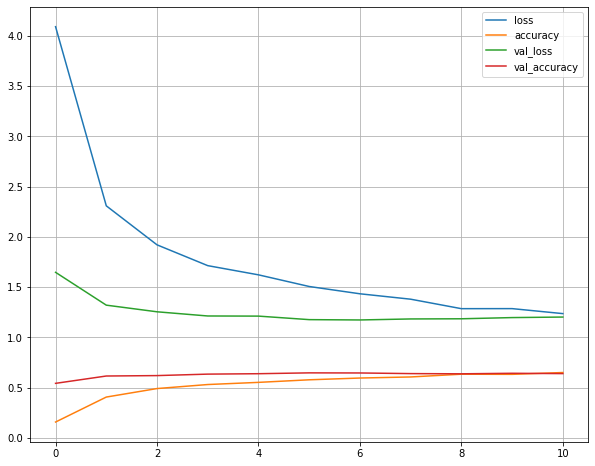

In [ ]:
warmup_model = build_warmup_parametrized_model(regularization="dropout",base_net="DenseNet169",reg_param=0.7,optimizer="SGD", learning_rate=0.005,loss="categorical_crossentropy")
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
batch_size = 64
steps_per_epoch = X_train[0:7040].shape[0] // batch_size 
validation_steps = X_train[7040:8000].shape[0] // batch_size 

history = warmup_model.fit(X_train[0:7040],y_train[0:7040],steps_per_epoch=steps_per_epoch, epochs=20, validation_data=(X_train[7040:8000],y_train[7040:8000]),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)
warmup_model.save_weights("warmup.hd5")
del warmup_model
gc.collect()
tf.keras.backend.clear_session()

## Hyperparameter tuning for fine-tuning
We have to tune the following hyperparameters:
- LR, with values 1e-4, 5e-4
- K = 250, 350* (number of base layers to freeze)
- Loss (KL/categorical cross-entropy)

We keep the Dropout regularization but we rise p to 0.8, since this stage is more delicate and incurring in overfitting is easier.
We also keep the SGD optimizer.

*As we can see in the following cell, there are 594 layers.

Notice that the validation is going to be slower than the EfficientNet case, because the number of non-frozen layers is way higher now.

In [ ]:
base_model = tf.keras.applications.DenseNet169(weights='imagenet', input_shape=(130, 130, 3), include_top=False)

for k, layer in enumerate(base_model.layers):
  print(str(k) + " " + layer.name)

0 input_7
1 zero_padding2d_8
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_9
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [ ]:
from sklearn.model_selection import KFold
from termcolor import colored

max_accuracy=0

for K in [250,350]:
  for loss in ['kl_divergence','categorical_crossentropy']: 
    for learning_rate in [5e-5,1e-4]:
        print(colored("\n\n\n\nK: "+str(K)+", Loss: "+str(loss)+", LR: "+str(learning_rate),"blue"));
        validation_steps = X_train[7040:8000].shape[0] // batch_size 
        steps_per_epoch = X_train[0:7040].shape[0] // batch_size 
    
        model = build_finetuning_parametrized_model(0.8,K,base_net="DenseNet169",regularization="dropout",optimizer="SGD", loss=loss,learning_rate=learning_rate)


        history = model.fit(X_train[0:7040], y_train[0:7040],
                            steps_per_epoch=steps_per_epoch, 
                            validation_data=(X_train[7040:8000],y_train[7040:8000]), 
                            validation_steps=validation_steps,
                            epochs=10, verbose=1, callbacks=[callback])
        accuracy = history.history['val_accuracy'][-1] 

        del model 
        tf.keras.backend.clear_session()  
        gc.collect()
        
        
        print(colored("Accuracy: "+str(accuracy)+" K: "+str(K)+" Loss: "+str(loss)+" LR: "+str(learning_rate),"green"));
        if accuracy > max_accuracy:
          max_accuracy = accuracy
          best_fine_K = K
          best_fine_lr = learning_rate
          best_fine_loss = loss
max_accuracy



  





K: 250, Loss: kl_divergence, LR: 5e-05
Epoch 1/10
110/110 [==============================] - 32s 195ms/step - loss: 1.5672 - accuracy: 0.5612 - val_loss: 1.2102 - val_accuracy: 0.6469
Epoch 2/10
110/110 [==============================] - 19s 175ms/step - loss: 1.4943 - accuracy: 0.5888 - val_loss: 1.2092 - val_accuracy: 0.6417
Epoch 3/10
110/110 [==============================] - 19s 174ms/step - loss: 1.4564 - accuracy: 0.5935 - val_loss: 1.1933 - val_accuracy: 0.6521
Epoch 4/10
110/110 [==============================] - 19s 173ms/step - loss: 1.4244 - accuracy: 0.6020 - val_loss: 1.2023 - val_accuracy: 0.6562
Epoch 5/10
110/110 [==============================] - 19s 173ms/step - loss: 1.3963 - accuracy: 0.6144 - val_loss: 1.1888 - val_accuracy: 0.6500
Epoch 6/10
110/110 [==============================] - 19s 173ms/step - loss: 1.3687 - accuracy: 0.6035 - val_loss: 1.1948 - val_accuracy: 0.6531
Epoch 7/10
110/110 [==============================] - 19s 173ms/step - loss: 1.3400 - a

0.6677083373069763

In [ ]:
print(best_fine_K)
print(best_fine_lr)
print(best_fine_loss)
print(max_accuracy)

250
0.0001
categorical_crossentropy
0.6677083373069763


## Full training and testing

Having found an estimate of the best hyperparameters, we can now do the warm-up and then fine-tune on the whole training set, using the best hyperparameters for warm-up and fine-tuning respectively.

To recap, for warm-up they are:
- LR = 0.005 
- Optimizer = SGD
- Dropout (p = 0.7)
- Loss = Categorical cross-entropy

and for fine-tuning (setting optimizer=SGD and using Dropout with p=0.8):
- K = 250
- LR = 0.0001
- Loss = Categorical cross-entropy

With warm-up we reach 65.6% accuracy (vs 61.4% with EfficientNetB0). After fine-tuning, we reach 67.3% accuracy (vs 65.1% with EfficientNetB0). So we prefer using DenseNet169 as a pre-trained network with this set of hyperparameters.

### Warm-up + fine-tuning

Epoch 1/50
125/125 [==============================] - 23s 121ms/step - loss: 4.9709 - accuracy: 0.0769 - val_loss: 1.6001 - val_accuracy: 0.5530
Epoch 2/50
125/125 [==============================] - 13s 101ms/step - loss: 2.3789 - accuracy: 0.3884 - val_loss: 1.3065 - val_accuracy: 0.6260
Epoch 3/50
125/125 [==============================] - 13s 101ms/step - loss: 1.8959 - accuracy: 0.4922 - val_loss: 1.2257 - val_accuracy: 0.6430
Epoch 4/50
125/125 [==============================] - 13s 100ms/step - loss: 1.6506 - accuracy: 0.5467 - val_loss: 1.1941 - val_accuracy: 0.6530
Epoch 5/50
125/125 [==============================] - 12s 100ms/step - loss: 1.5666 - accuracy: 0.5627 - val_loss: 1.1756 - val_accuracy: 0.6640
Epoch 6/50
125/125 [==============================] - 12s 99ms/step - loss: 1.4660 - accuracy: 0.5919 - val_loss: 1.1577 - val_accuracy: 0.6610
Epoch 7/50
125/125 [==============================] - 12s 100ms/step - loss: 1.4017 - accuracy: 0.6015 - val_loss: 1.1568 - val_acc

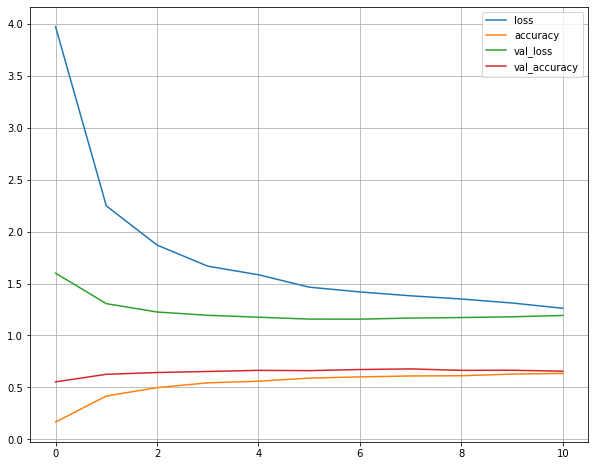

Epoch 1/50
125/125 [==============================] - 33s 192ms/step - loss: 1.5937 - accuracy: 0.5677 - val_loss: 1.1998 - val_accuracy: 0.6580
Epoch 2/50
125/125 [==============================] - 22s 175ms/step - loss: 1.4865 - accuracy: 0.5869 - val_loss: 1.2021 - val_accuracy: 0.6630
Epoch 3/50
125/125 [==============================] - 22s 173ms/step - loss: 1.5115 - accuracy: 0.5783 - val_loss: 1.1580 - val_accuracy: 0.6620
Epoch 4/50
125/125 [==============================] - 21s 172ms/step - loss: 1.4205 - accuracy: 0.6057 - val_loss: 1.1450 - val_accuracy: 0.6660
Epoch 5/50
125/125 [==============================] - 22s 172ms/step - loss: 1.4096 - accuracy: 0.6106 - val_loss: 1.1371 - val_accuracy: 0.6710
Epoch 6/50
125/125 [==============================] - 22s 173ms/step - loss: 1.3703 - accuracy: 0.6165 - val_loss: 1.1500 - val_accuracy: 0.6650
Epoch 7/50
125/125 [==============================] - 22s 173ms/step - loss: 1.2957 - accuracy: 0.6314 - val_loss: 1.1384 - val_ac

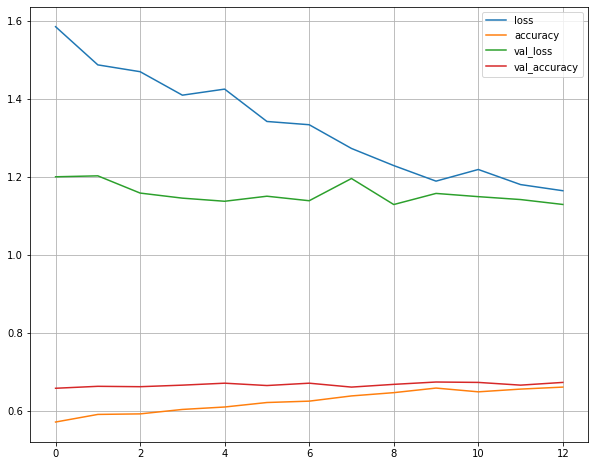

In [ ]:
warmup_model = build_warmup_parametrized_model(0.7,base_net='DenseNet169',regularization='dropout',optimizer='SGD',loss='categorical_crossentropy',learning_rate=0.005);
validation_steps = X_test.shape[0] // 64 
steps_per_epoch = X_train.shape[0] // 64

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history = warmup_model.fit(X_train,y_train,steps_per_epoch=steps_per_epoch, epochs=50, validation_data=(X_test,y_test),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)

warmup_model.save_weights("warmup.hd5")
del warmup_model
tf.keras.backend.clear_session()  

final_model = build_finetuning_parametrized_model(0.8,250,base_net='DenseNet169',regularization='dropout',optimizer='SGD',learning_rate=0.0001,loss="categorical_crossentropy");
history = final_model.fit(X_train,y_train,steps_per_epoch=steps_per_epoch, epochs=50, validation_data=(X_test,y_test),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)

tf.keras.models.save_model(final_model,"130px_with_densenet.h5");

### Confusion matrix

We can also calculate and plot the confusion matrix on the testing set (the (i,j)-th entry is the number of class-i samples predicted as class-j). The labels are reconverted from one-hot encoding to 0...119.

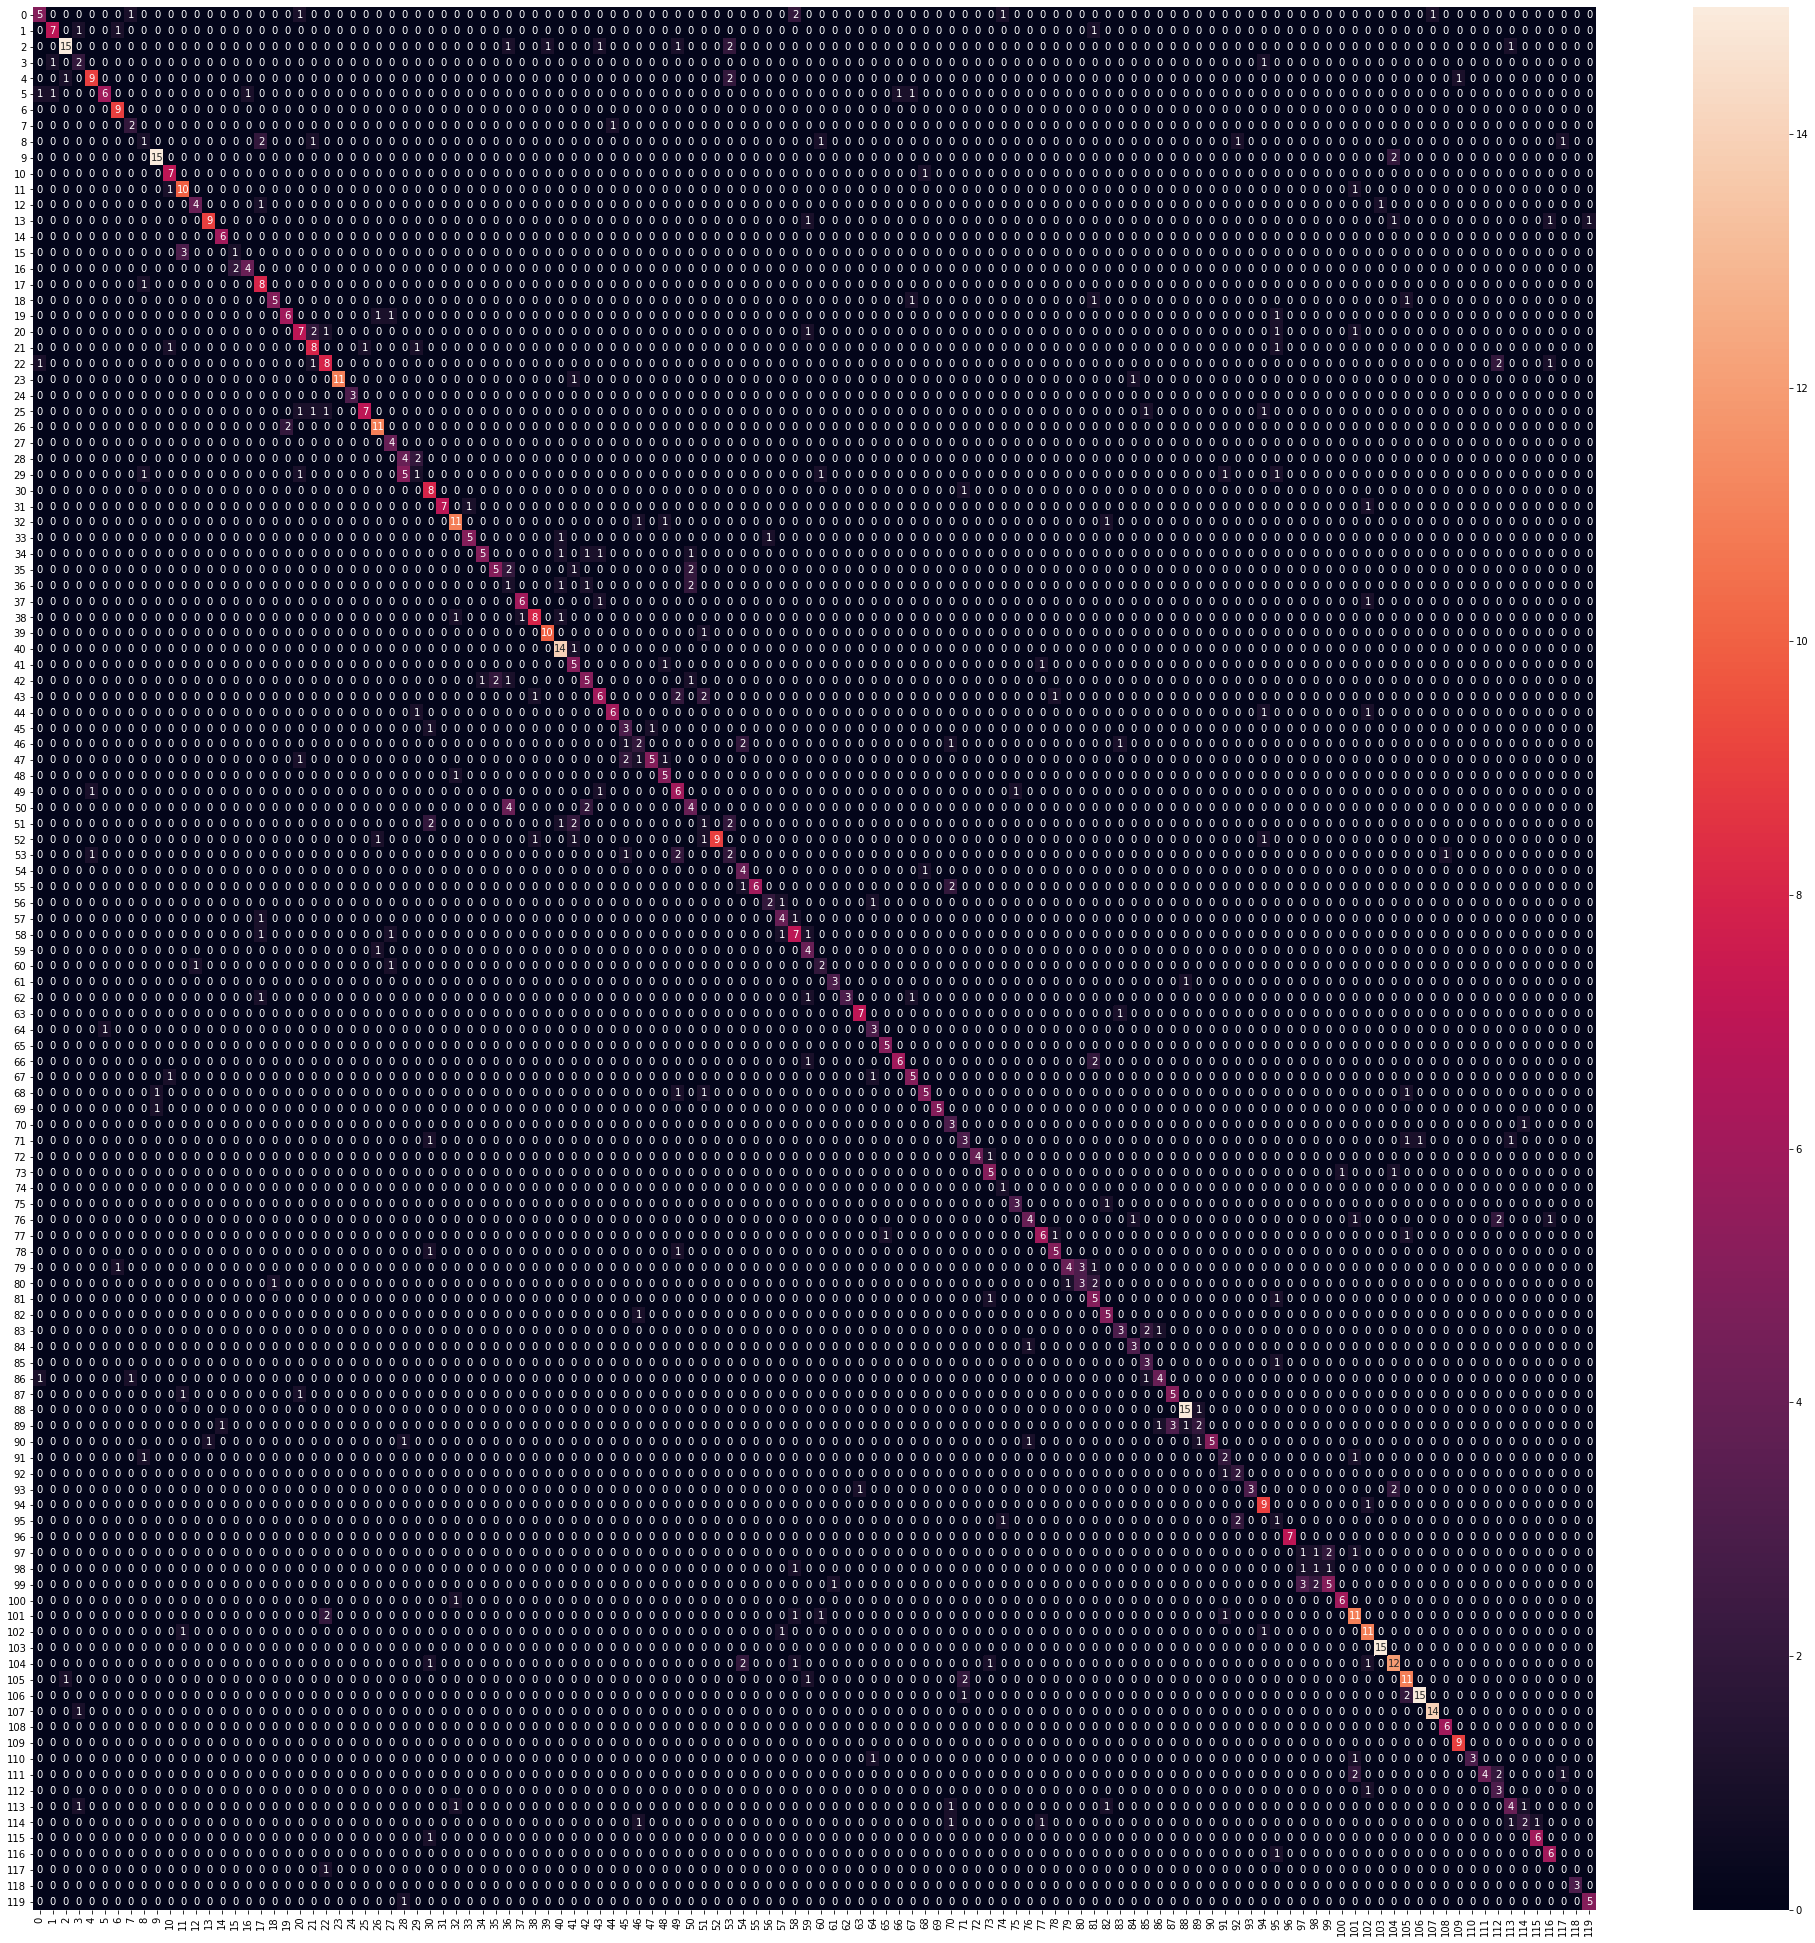

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
y_pred = final_model.predict(X_test);
y_pred = ohe.inverse_transform(y_pred);
y_true = ohe.inverse_transform(y_test);

labels_range = np.asarray(range(0,120));

mat = confusion_matrix(y_true, y_pred, labels=labels_range)
df_cm = pd.DataFrame(mat, index = [i for i in labels_range],
                  columns = [i for i in labels_range])
plt.figure(figsize = (35,35))
sn.heatmap(df_cm, annot=True)

### Class prediction for downloaded image

Again, we can test the model using an image of an Airedale dog downloaded from the web (https://commons.wikimedia.org/wiki/File:Airedale_terrier_head,_Josselin_01.jpg). The true label is 40.


(-0.5, 799.5, 599.5, -0.5)

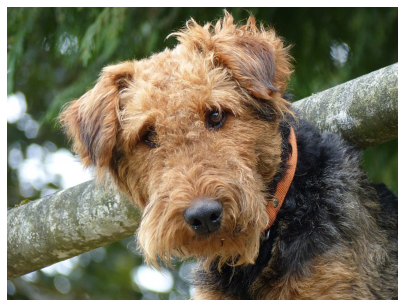

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    "airedale.jpg", grayscale=False, color_mode='rgb',
    interpolation='nearest'
)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.axis('off')

We now reshape it into a 130x130 image:

(-0.5, 129.5, 129.5, -0.5)

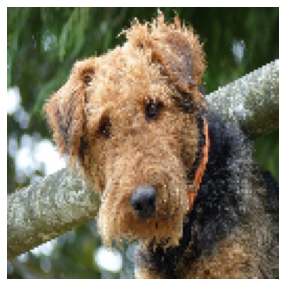

In [ ]:
img = np.asarray(img)
img = tf.image.resize(img, (130,130))
plt.figure(figsize=(5, 5))
plt.imshow(img/255)
plt.axis('off')

And then we use it for predicting the label, knowing that the true label is 40. The prediction is 40, which is correct.

In [ ]:
img = np.asarray([img])
img_y_true = 40
img_y_pred = final_model.predict(img);
img_y_pred = ohe.inverse_transform(img_y_pred);
print("Ground truth: ",img_y_true," Predicted label: ",img_y_pred[0]);

Ground truth:  40  Predicted label:  [40.]


### Performance without data augmentation

As before, just for the sake of testing, we can see how the training would affect the model if we didn't augment the data. Once again, we get similar accuracy, but the signs of overfitting are evident.

Epoch 1/50
125/125 [==============================] - 21s 109ms/step - loss: 4.8270 - accuracy: 0.0972 - val_loss: 1.5593 - val_accuracy: 0.5830
Epoch 2/50
125/125 [==============================] - 11s 90ms/step - loss: 1.9995 - accuracy: 0.4745 - val_loss: 1.2676 - val_accuracy: 0.6400
Epoch 3/50
125/125 [==============================] - 11s 91ms/step - loss: 1.5723 - accuracy: 0.5603 - val_loss: 1.1956 - val_accuracy: 0.6530
Epoch 4/50
125/125 [==============================] - 11s 91ms/step - loss: 1.3357 - accuracy: 0.6109 - val_loss: 1.1518 - val_accuracy: 0.6620
Epoch 5/50
125/125 [==============================] - 11s 92ms/step - loss: 1.2119 - accuracy: 0.6462 - val_loss: 1.1548 - val_accuracy: 0.6640
Epoch 6/50
125/125 [==============================] - 11s 92ms/step - loss: 1.1440 - accuracy: 0.6670 - val_loss: 1.1440 - val_accuracy: 0.6590
Epoch 7/50
125/125 [==============================] - 12s 92ms/step - loss: 1.0778 - accuracy: 0.6748 - val_loss: 1.1386 - val_accuracy

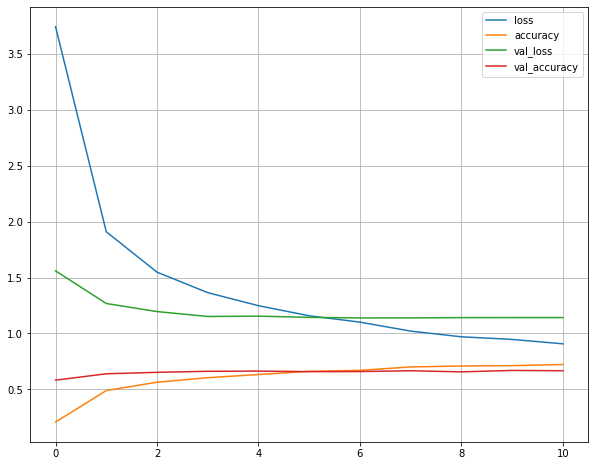

Epoch 1/50
125/125 [==============================] - 32s 184ms/step - loss: 1.2245 - accuracy: 0.6414 - val_loss: 1.1217 - val_accuracy: 0.6800
Epoch 2/50
125/125 [==============================] - 21s 168ms/step - loss: 1.1338 - accuracy: 0.6700 - val_loss: 1.1192 - val_accuracy: 0.6780
Epoch 3/50
125/125 [==============================] - 21s 166ms/step - loss: 1.0675 - accuracy: 0.6798 - val_loss: 1.1201 - val_accuracy: 0.6670
Epoch 4/50
125/125 [==============================] - 21s 165ms/step - loss: 0.9972 - accuracy: 0.6993 - val_loss: 1.1287 - val_accuracy: 0.6820
Epoch 5/50
125/125 [==============================] - 21s 166ms/step - loss: 0.9760 - accuracy: 0.7028 - val_loss: 1.1350 - val_accuracy: 0.6800
Epoch 6/50
125/125 [==============================] - 21s 167ms/step - loss: 0.9202 - accuracy: 0.7145 - val_loss: 1.1035 - val_accuracy: 0.6710
Epoch 7/50
125/125 [==============================] - 21s 166ms/step - loss: 0.9007 - accuracy: 0.7135 - val_loss: 1.1215 - val_ac

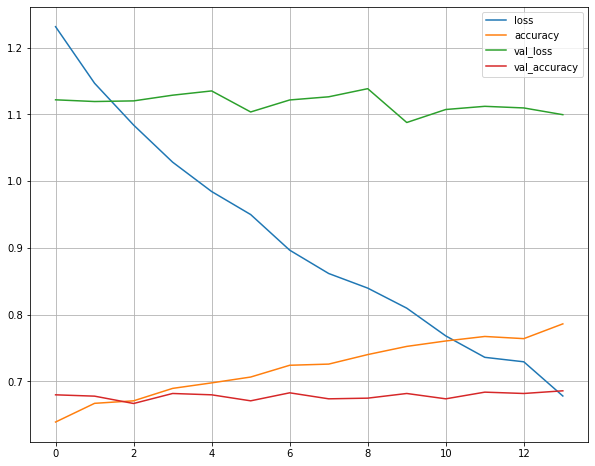

In [ ]:
warmup_model_no_aug = build_warmup_parametrized_model(0.7,with_augmentation=False,base_net='DenseNet169',regularization='dropout',optimizer='SGD',loss='categorical_crossentropy',learning_rate=0.005);
validation_steps = X_test.shape[0] // 64 
steps_per_epoch = X_train.shape[0] // 64

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history = warmup_model_no_aug.fit(X_train,y_train,steps_per_epoch=steps_per_epoch, epochs=50, validation_data=(X_test,y_test),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)

warmup_model_no_aug.save_weights("warmup.hd5")
del warmup_model_no_aug
tf.keras.backend.clear_session()  

final_model_no_aug = build_finetuning_parametrized_model(0.8,250,with_augmentation=False,base_net='DenseNet169',regularization='dropout',optimizer='SGD',learning_rate=0.0001,loss="categorical_crossentropy");
history = final_model_no_aug.fit(X_train,y_train,steps_per_epoch=steps_per_epoch, epochs=50, validation_data=(X_test,y_test),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)
del final_model_no_aug
tf.keras.backend.clear_session() 

# Training with 150x150 images

We now want to test the performance using the same hyperparameters found above with DenseNet169, using 150x150 images. We expect an increase in accuracy.

Restart the session to free space. Execute the following cell, then re-execute the previous "Architecture building" cells before proceeding.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tqdm import tqdm
from keras.callbacks import EarlyStopping as es
import gc
import keras
from sklearn.preprocessing import OneHotEncoder 
import tensorflow as tf


data = tfds.load("stanford_dogs")
train, test = data["train"], data["test"]

def dataset_to_numpy(data, img_shape, num_samples=0):
  if num_samples == 0:
    num_samples = data.cardinality()
  
  it = data.as_numpy_iterator()
  train_X = np.zeros((num_samples, img_shape[0], img_shape[1],  3))
  train_Y = np.zeros(num_samples)
 
  
  for i in tqdm(range(num_samples)):
    
    im = next(it)
    curr = np.asarray(im['image'])
    curr = tf.image.resize(curr, img_shape)
    train_X[i, :, :, :] = curr
    
    train_Y[i] = im['label']

  return train_X, train_Y

img_size = 150

X_train, y_train = dataset_to_numpy(train, (img_size,img_size), 8000)
X_test, y_test = dataset_to_numpy(test, (img_size,img_size), 1000)



#elimino il dataset originale
del train 
del test
del data
gc.collect()  #forzo garbage collection

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete2PGORJ/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete2PGORJ/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


100%|██████████| 1000/1000 [00:03<00:00, 317.09it/s]


1437

In [ ]:
ohe = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train),1)
y_test = y_test.reshape(len(y_test),1)
ohe.fit(y_train)
y_train = ohe.transform(y_train)
y_test = ohe.transform(y_test)

## Full training and testing 
Execute the following cell only after having execute the "Architecture building" cells above!

As we can see, there is indeed an increase in accuracy. After warm-up, we reach 70.3%. After fine-tuning, we reach 70.9% that is a better accuracy than the one we got with 130x130 images.

### Warm-up + fine-tuning

Epoch 1/50
125/125 [==============================] - 27s 157ms/step - loss: 4.7491 - accuracy: 0.0967 - val_loss: 1.3676 - val_accuracy: 0.6210
Epoch 2/50
125/125 [==============================] - 17s 136ms/step - loss: 2.0073 - accuracy: 0.4631 - val_loss: 1.1272 - val_accuracy: 0.6800
Epoch 3/50
125/125 [==============================] - 17s 134ms/step - loss: 1.6447 - accuracy: 0.5413 - val_loss: 1.0715 - val_accuracy: 0.6730
Epoch 4/50
125/125 [==============================] - 17s 133ms/step - loss: 1.4727 - accuracy: 0.5897 - val_loss: 1.0402 - val_accuracy: 0.6800
Epoch 5/50
125/125 [==============================] - 17s 134ms/step - loss: 1.3123 - accuracy: 0.6257 - val_loss: 1.0109 - val_accuracy: 0.6890
Epoch 6/50
125/125 [==============================] - 17s 135ms/step - loss: 1.2766 - accuracy: 0.6381 - val_loss: 0.9953 - val_accuracy: 0.7020
Epoch 7/50
125/125 [==============================] - 17s 135ms/step - loss: 1.2035 - accuracy: 0.6361 - val_loss: 1.0218 - val_ac

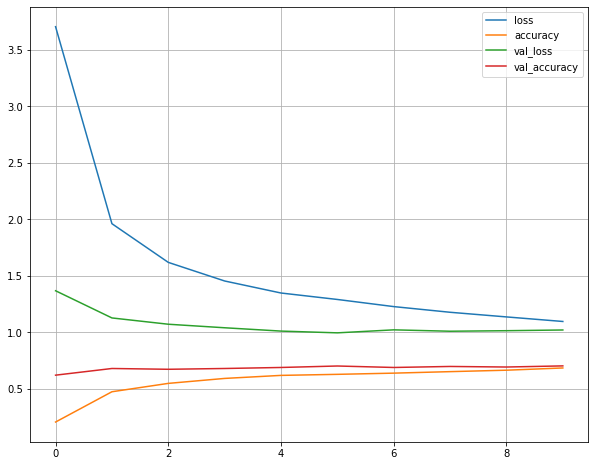

Epoch 1/50
125/125 [==============================] - 40s 242ms/step - loss: 1.4091 - accuracy: 0.6061 - val_loss: 1.0097 - val_accuracy: 0.7010
Epoch 2/50
125/125 [==============================] - 28s 223ms/step - loss: 1.3445 - accuracy: 0.6160 - val_loss: 1.0027 - val_accuracy: 0.7080
Epoch 3/50
125/125 [==============================] - 28s 221ms/step - loss: 1.2702 - accuracy: 0.6339 - val_loss: 0.9830 - val_accuracy: 0.7080
Epoch 4/50
125/125 [==============================] - 28s 222ms/step - loss: 1.2115 - accuracy: 0.6470 - val_loss: 1.0042 - val_accuracy: 0.7000
Epoch 5/50
125/125 [==============================] - 28s 223ms/step - loss: 1.1672 - accuracy: 0.6546 - val_loss: 1.0094 - val_accuracy: 0.7110
Epoch 6/50
125/125 [==============================] - 28s 222ms/step - loss: 1.1637 - accuracy: 0.6627 - val_loss: 0.9763 - val_accuracy: 0.7140
Epoch 7/50
125/125 [==============================] - 28s 222ms/step - loss: 1.1134 - accuracy: 0.6707 - val_loss: 1.0145 - val_ac

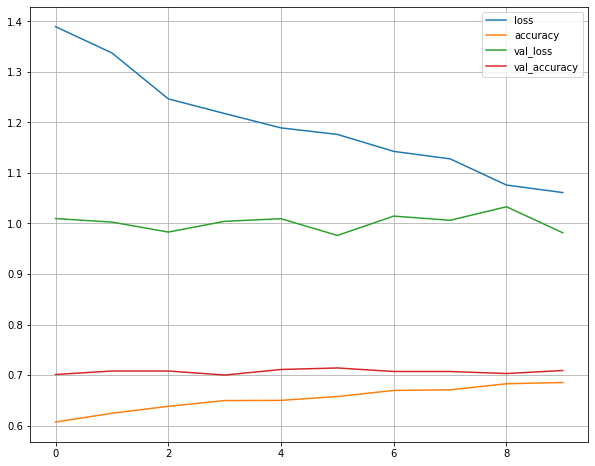

In [ ]:
warmup_model = build_warmup_parametrized_model(0.7,base_net='DenseNet169',regularization='dropout',optimizer='SGD',loss='categorical_crossentropy',learning_rate=0.005);
validation_steps = X_test.shape[0] // 64 
steps_per_epoch = X_train.shape[0] // 64
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history = warmup_model.fit(X_train,y_train,steps_per_epoch=steps_per_epoch, epochs=50, validation_data=(X_test,y_test),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)

warmup_model.save_weights("warmup.hd5")
del warmup_model
tf.keras.backend.clear_session()  

final_model = build_finetuning_parametrized_model(0.8,250,base_net='DenseNet169',regularization='dropout',optimizer='SGD',learning_rate=0.0001,loss="categorical_crossentropy");
history = final_model.fit(X_train,y_train,steps_per_epoch=steps_per_epoch, epochs=50, validation_data=(X_test,y_test),validation_steps=validation_steps,callbacks=[callback])
plot_losses(history)

tf.keras.models.save_model(final_model,"150px_with_densenet.h5");

### Confusion matrix

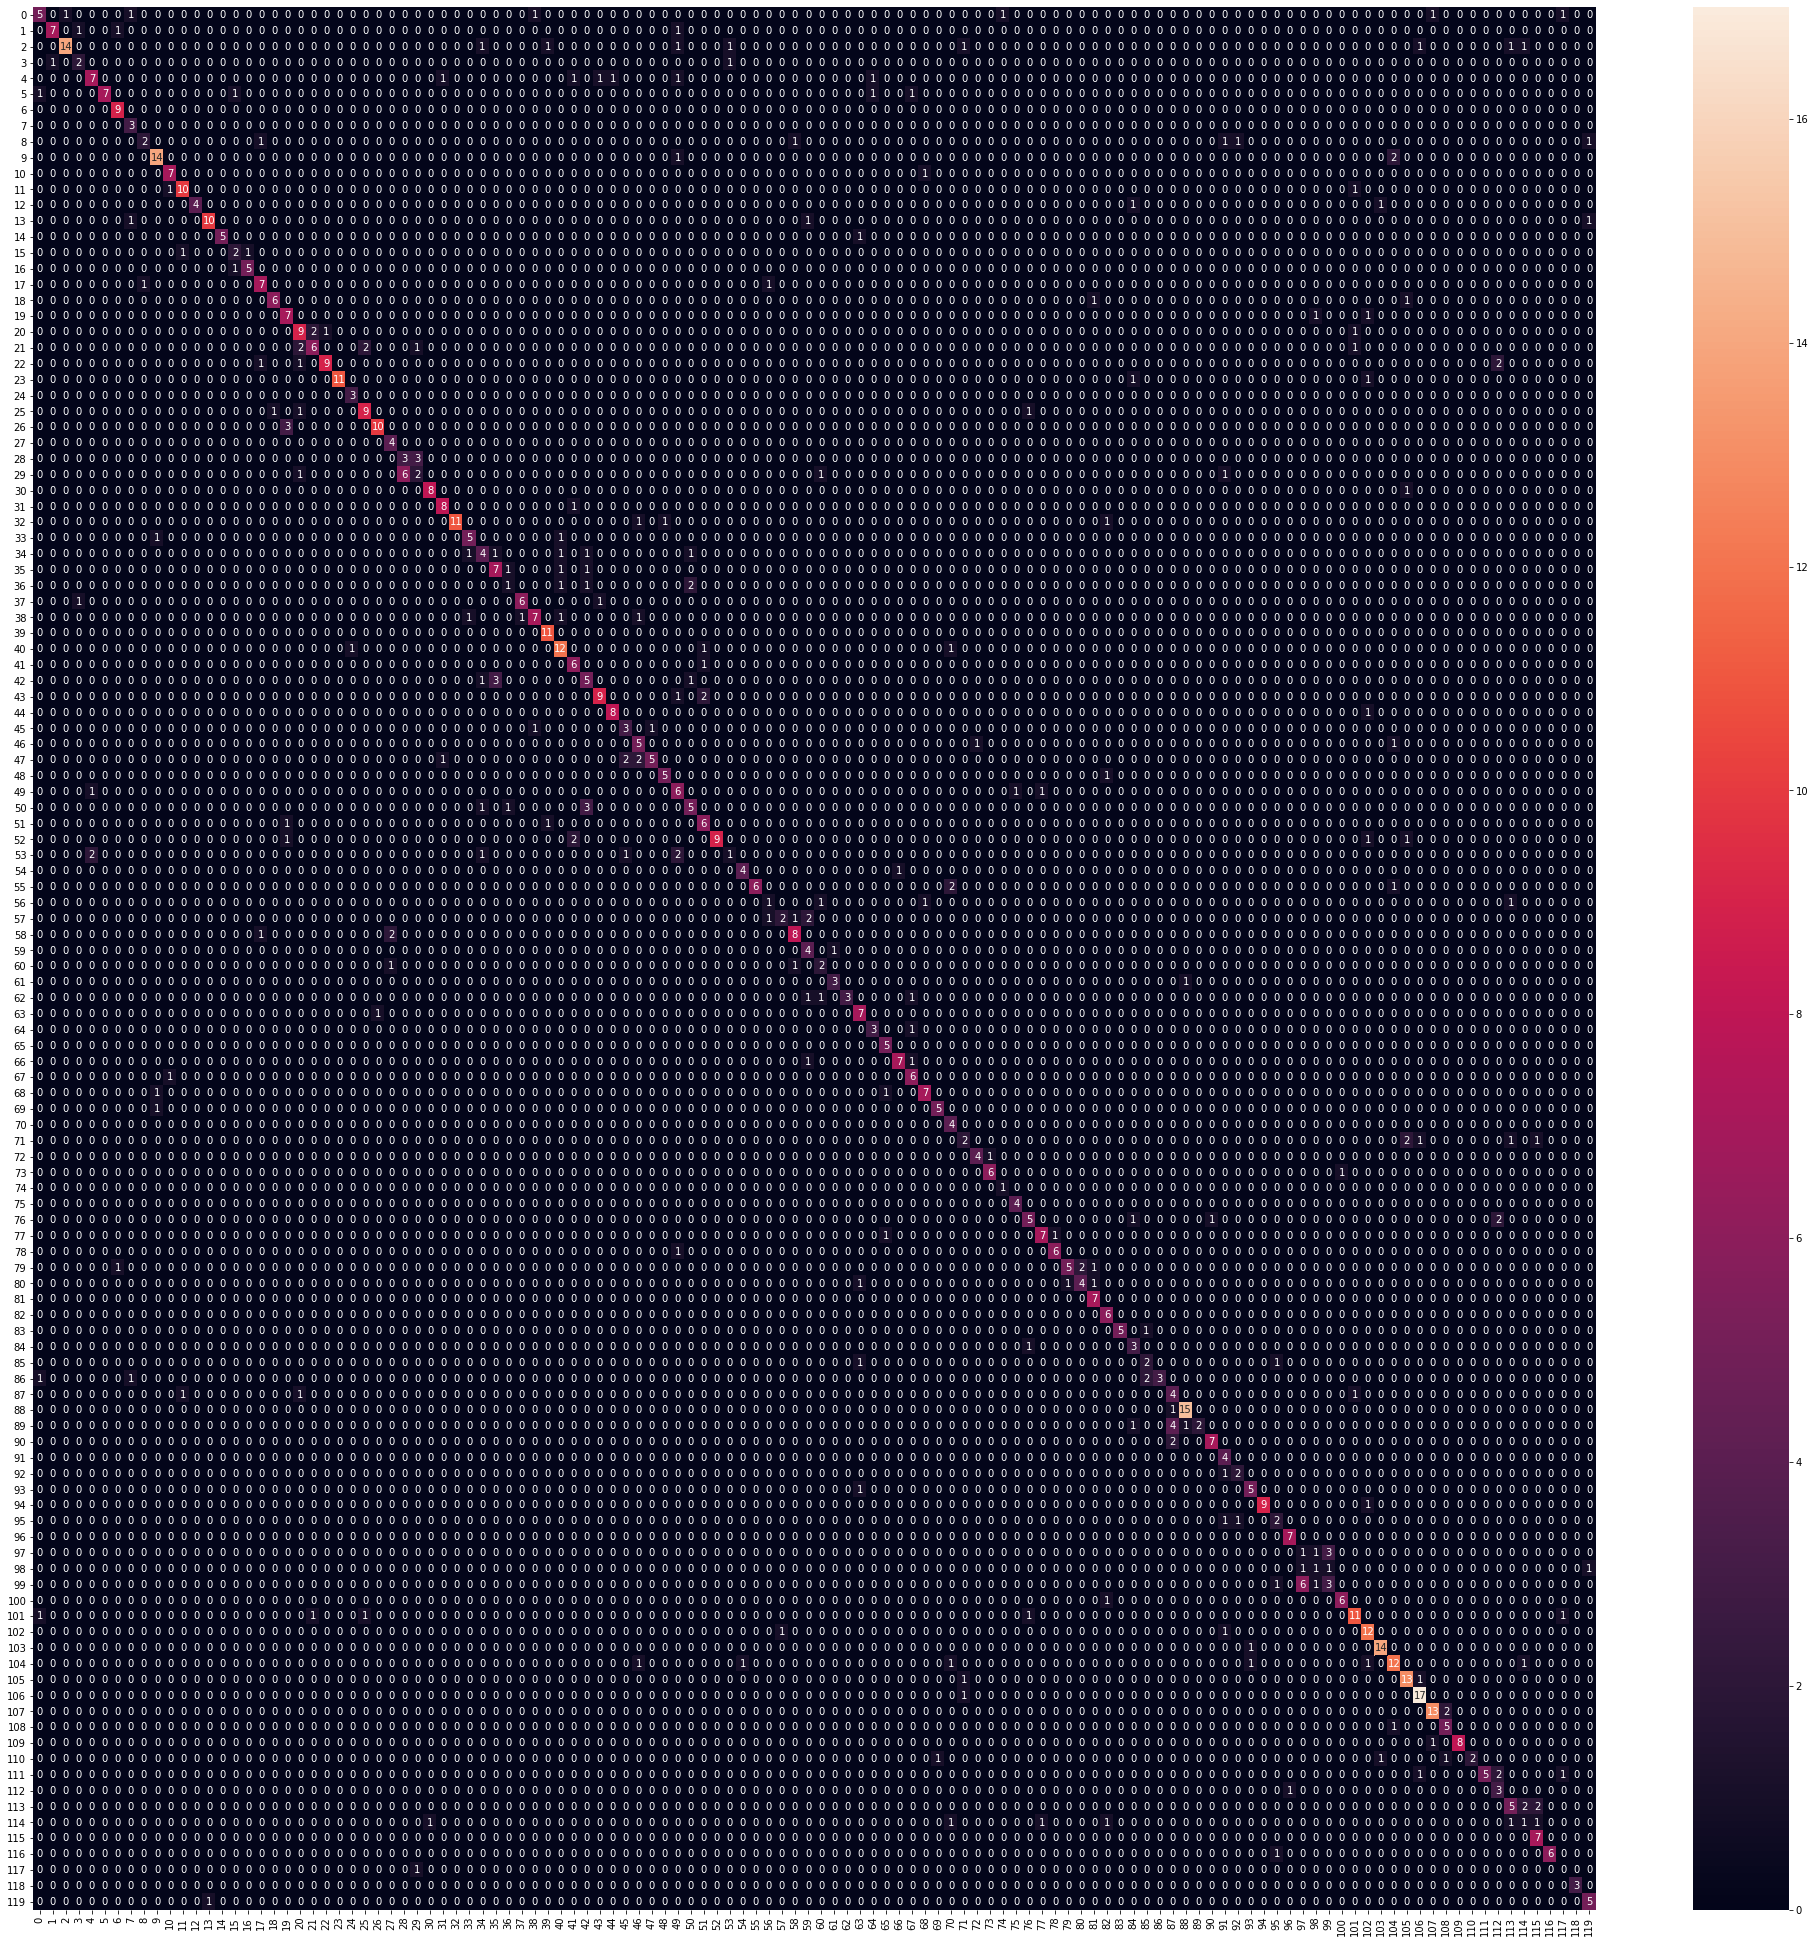

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
y_pred = final_model.predict(X_test);
y_pred = ohe.inverse_transform(y_pred);
y_true = ohe.inverse_transform(y_test);

labels_range = np.asarray(range(0,120));

mat = confusion_matrix(y_true, y_pred, labels=labels_range)
df_cm = pd.DataFrame(mat, index = [i for i in labels_range],
                  columns = [i for i in labels_range])
plt.figure(figsize = (35,35))
sn.heatmap(df_cm, annot=True)

### Class prediction for downloaded image

In the end, we test it on an image of a Bernese Mountain dog downloaded from the web (https://www.montevento.net/en/). The true label is 88.

(-0.5, 494.5, 399.5, -0.5)

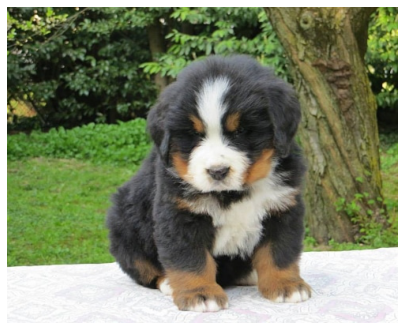

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    "bernese.jpg", grayscale=False, color_mode='rgb',
    interpolation='nearest'
)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.axis('off')

We now reshape it into a 150x150 image:

(-0.5, 149.5, 149.5, -0.5)

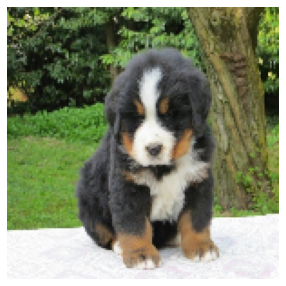

In [ ]:
img = np.asarray(img)
img = tf.image.resize(img, (150,150))
plt.figure(figsize=(5, 5))
plt.imshow(img/255)
plt.axis('off')

And then we use it for predicting the label, knowing that the true label is 88. The prediction is 88, which is correct.

In [ ]:
img = np.asarray([img])
img_y_true = 88
img_y_pred = final_model.predict(img);
img_y_pred = ohe.inverse_transform(img_y_pred);
print("Ground truth: ",img_y_true," Predicted label: ",img_y_pred[0]);

Ground truth:  88  Predicted label:  [88.]
